In [1]:
%matplotlib notebook
#%matplotlib inline
import sys
sys.path.append("../../NephNet")
import matplotlib.pyplot as plt
import os
import random
import shutil
import time
import warnings
import sys
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from data_loader import databases as module_datasets
from base.base_data_loader import BaseDataLoader
from trainer import Trainer
from utils import Logger
from utils import util
from utils import tSNE_test as tSNE#import Identity, tSNE_generator
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
from utils import hyperband as HypOpt
import argparse
from sklearn.model_selection import StratifiedKFold
import copy
from utils import transforms3d as t3d
import pandas as pd

import cleanlab
from cleanlab import baseline_methods
from sklearn.metrics import accuracy_score

print("Modules loaded")


importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(tSNE)
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
importlib.reload(HypOpt)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded
Reload complete
GPUs available: 1


In [4]:
config_file = '../configs/config_kfold.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [5]:
def main(config):
    cv_n_folds = 4
    myfiles = []
    for i in range(cv_n_folds):
        print("\n=======FOLD {} / {} ========".format(i+1, cv_n_folds))
        filename = one_fold(config, cv_n_folds, i)
        myfiles.append(filename)
    print(myfiles)
    combine_folds(config, myfiles, cv_n_folds)


def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])


def one_fold(config, cv_n_folds, cv_fold):
    print("GPUs available: " + str(torch.cuda.device_count()))
    train_logger = Logger()
    cv_seed = 1234
    np.random.seed(cv_seed)
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
    num_classes = config['arch']['args']['num_classes']
    #cudnn.benchmark = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #Initialize training dataset
    rs = np.random.RandomState()
    mean = config['data_loader']['args']['mean']
    stdev = config['data_loader']['args']['stdev']
    trsfm_train = [
                   t3d.RandomRotate90(rs), 
                   t3d.Normalize(mean, stdev), 
                   t3d.ToTensor(True)]
    train_dataset = getattr(module_datasets, 
        'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
        shape = config['data_loader']['args']['shape'], 
        transforms = trsfm_train,
        training = True)
    
    my_imgs_idx = np.random.choice(range(len(train_dataset.data)), size=5000, replace=False,)
    #train_dataset.data = train_dataset.data[my_imgs_idx]
    #train_dataset.label = train_dataset.label[my_imgs_idx]
    labels = [label for img, label in train_dataset]
    # Split train into train and holdout for particular cv_fold.
    kf = StratifiedKFold(n_splits = cv_n_folds, shuffle = True, random_state = cv_seed)
    cv_train_idx, cv_holdout_idx = list(kf.split(range(len(labels)), labels))[cv_fold]
    
    # CREATE SEPARATE DATASETS       
    #holdout_dataset = copy.deepcopy(train_dataset)
    holdout_dataset = getattr(module_datasets, 
        'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
        shape = config['data_loader']['args']['shape'], 
        transforms = trsfm_train,
        training = True)
    holdout_dataset.data = np.array([train_dataset.data[i] for i in cv_holdout_idx])
    holdout_dataset.label = np.array([train_dataset.label[i] for i in cv_holdout_idx])
    holdout_dataset.data_len = holdout_dataset.data.shape[0]
    #holdout_dataset.samples = holdout_dataset.data
    # Subset of holdout used to choose the best model.
    #val_dataset = copy.deepcopy(holdout_dataset)
    val_dataset = getattr(module_datasets, 
        'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
        shape = config['data_loader']['args']['shape'], 
        transforms = trsfm_train,
        training = True)
    val_dataset.data = copy.deepcopy(holdout_dataset.data)
    val_size = int(len(cv_holdout_idx) / 5)
    val_imgs_idx = np.random.choice(range(len(holdout_dataset.data)), size=val_size, replace=False,)
    val_dataset.data = np.array([holdout_dataset.data[i] for i in val_imgs_idx])
    val_dataset.label = np.array([holdout_dataset.label[i] for i in val_imgs_idx])
    val_dataset.data_len = val_dataset.data.shape[0]
    #val_dataset.samples = val_dataset.imgs
    train_dataset.data = np.array([train_dataset.data[i] for i in cv_train_idx])
    train_dataset.label = np.array([train_dataset.label[i] for i in cv_train_idx])
    train_dataset.data_len = train_dataset.data.shape[0]
    #train_dataset.samples = train_dataset.imgs
    print('Train size:', len(cv_train_idx), len(train_dataset.data))
    print('Holdout size:', len(cv_holdout_idx), len(holdout_dataset.data))
    print('Val size (subset of holdout):', len(val_imgs_idx), len(val_dataset.data))


    
    
    
    
   #create data_loaders
    train_loader = hdf5_3d_dataloader(
        config['data_loader']['args']['hdf5_path'],
        config['data_loader']['args']['batch_size'],
        shuffle = config['data_loader']['args']['shuffle'],
        shape = config['data_loader']['args']['shape'],
        num_workers = config['data_loader']['args']['num_workers'],
        training = config['data_loader']['args']['training'],
        dataset = train_dataset,
        mean = config['data_loader']['args']['mean'],
        stdev = config['data_loader']['args']['stdev'])

    val_loader = hdf5_3d_dataloader(
        config['data_loader']['args']['hdf5_path'],
        config['data_loader']['args']['batch_size'],
        shuffle = config['data_loader']['args']['shuffle'],
        shape = config['data_loader']['args']['shape'],
        num_workers = config['data_loader']['args']['num_workers'],
        training = config['data_loader']['args']['training'],
        dataset = val_dataset,
        mean = config['data_loader']['args']['mean'],
        stdev = config['data_loader']['args']['stdev'])
    
    model = get_instance(module_arch, 'arch', config)
    train_logger = Logger()
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(train_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']]

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=None,
                      config=config,
                      data_loader=train_loader,
                      valid_data_loader=val_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)

    trainer.train()

    # Load model best and make predictions on holdout dataset
    holdout_loader = hdf5_3d_dataloader(
        config['data_loader']['args']['hdf5_path'],
        config['data_loader']['args']['batch_size'],
        shuffle = False, #config['data_loader']['args']['shuffle'],
        shape = config['data_loader']['args']['shape'],
        num_workers = config['data_loader']['args']['num_workers'],
        training = config['data_loader']['args']['training'],
        dataset = holdout_dataset,
        mean = config['data_loader']['args']['mean'],
        stdev = config['data_loader']['args']['stdev'])
    
    saved_dir = trainer.checkpoint_dir
    best_model = os.path.join(saved_dir, "model_best.pth")
    print("=> loading {}".format(best_model))

    checkpoint = torch.load(best_model)
    model.load_state_dict(checkpoint['state_dict'])
    print("Running forward pass on holdout set of size:", len(holdout_dataset.data))
    probs = get_probs(holdout_loader, model)
    preds = np.argmax(probs, axis=1)
    labels = holdout_dataset.label -1
    acc = accuracy_score(labels, preds)
    print("\nAccuracy: {:.4f}".format(acc)) 
    filename = os.path.join( saved_dir, 'model_{}__fold_{}_probs.npy'.format(config['name'], cv_fold+1))
    
    np.save(filename, probs)    
    return filename




def get_probs(loader, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # switch to evaluate mode
    model.eval()
    ntotal = len(loader.dataset.data) / float(loader.batch_size)
    outputs = []
    with torch.no_grad():
        end = time.time()
        for i, (data, target) in enumerate(loader):
            print("\rComplete: {:.1%}".format(i / ntotal), end = "")
            if torch.cuda.is_available():
                data = data.to(device)
            target = target.to(device)

            # compute output
            outputs.append(model(data))
    
    # Prepare outputs as a single matrix
    probs = np.concatenate([
        torch.nn.functional.softmax(z, dim = 1) if not torch.cuda.is_available() else 
        torch.nn.functional.softmax(z, dim = 1).cpu().numpy() 
        for z in outputs
    ])
    
    return probs


def combine_folds(config, files, nfolds):
    cv_seed = 1234
    np.random.seed(cv_seed)
    a = os.path.join(config['trainer']['save_dir'], config['name'])
    wfn = os.path.join(a, 'combined_folds_{}.npy'.format(config['name']))
    print('This method will overwrite file: {}'.format(wfn))
    print('Computing fold indices. This takes 15 seconds.')
    # Prepare labels
    rs = np.random.RandomState()
    mean = config['data_loader']['args']['mean']
    stdev = config['data_loader']['args']['stdev']
    trsfm_train = [
                   t3d.Normalize(mean, stdev), 
                   t3d.ToTensor(True)]
    train_dataset = getattr(module_datasets, 
        'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
        shape = config['data_loader']['args']['shape'], 
        transforms = trsfm_train,
        training = True)
    
    my_imgs_idx = np.random.choice(range(len(train_dataset.data)), size=5000, replace=False,)
    #train_dataset.data = train_dataset.data[my_imgs_idx]
    #train_dataset.label = train_dataset.label[my_imgs_idx]
    
    labels = train_dataset.label - 1
    #plt.hist(labels, bins  = 'auto')
    #plt.show()
    num_classes = config['arch']['args']['num_classes']
    # Intialize pyx array (output of trained network)
    pyx = np.empty((len(labels), num_classes))
    # Split train into train and holdout for each cv_fold.
    kf = StratifiedKFold(n_splits = nfolds, shuffle = True, random_state = cv_seed)
    for k, (cv_train_idx, cv_holdout_idx) in enumerate(kf.split(range(len(labels)), labels)):
        tmp = len(cv_holdout_idx)
        probs = np.load(files[k]) 
        #cv_holdout_idx = cv_holdout_idx[:len(probs)]
        for i, idx in enumerate(cv_holdout_idx):
            pyx[idx] = probs[i]

    print('Writing final predicted probabilities.')
    #pyx = pyx[~np.isnan(pyx).any(axis=1)] #remove any rows that contain NAN
    np.save(wfn, pyx) 
    #plt.hist(np.argmax(pyx, axis=1), bins  = 'auto')
    #plt.show()
    #print(np.argmax(pyx, axis=1)[:25])
    #print(labels[:25])
    # Compute overall accuracy
    print('Computing Accuracy.', flush=True)
    preds = np.argmax(pyx, axis=1)
    acc = accuracy_score(labels, preds)
    print('Accuracy: {:.25}'.format(acc))

class hdf5_3d_dataloader(BaseDataLoader):
    '''
    3D augmentations use a random state to peform augmentation, which is organized as a List rather than torch.Compose()
    '''
    def __init__(self, hdf5_path, batch_size, shuffle=True, shape = [7,32,32], validation_split=0.0, num_workers=1, training=True, dataset = None, mean = 0, stdev = 1):
        rs = np.random.RandomState()
        trsfm_train = [
                       t3d.RandomRotate90(rs), 
                       t3d.Normalize(mean, stdev), 
                       t3d.ToTensor(True)]
        
        trsfm_test = [t3d.Normalize(mean, stdev), 
                      t3d.ToTensor(True)]
        if training == True:
            trsfm = trsfm_train
        else:
            trsfm = trsfm_test       
        
        self.hdf5_path = hdf5_path
        self.batch_size = batch_size
        self.shape = shape
        #importlib.reload(databases) #used to get load any recent changes from database class
        if dataset == None:
            self.dataset = module_datasets.hdf5dataset(hdf5_path, shape = self.shape, training = training, transforms=trsfm)
        else:
            self.dataset = dataset
        super(hdf5_3d_dataloader, self).__init__(self.dataset, batch_size, shuffle, validation_split, num_workers)

In [6]:
if torch.cuda.is_available():
    print("Using GPU: " + torch.cuda.get_device_name(0))
else:
    print("Using CPU to test")

main(config)


Using GPU: GeForce RTX 2080 Ti

=======FOLD 1 / 4 ========
GPUs available: 1


Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Train size: 104709 104709
Holdout size: 34908 34908
Val size (subset of holdout): 6981 6981


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn

Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_141547\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.3136742864627395
    accuracy       : 0.5023351648351648
    f1             : 0.5004451211108825
    balanced_accuracy: 0.5014404639872314
    precision      : 0.5299249639207662
    recall         : 0.5023351648351648
    val_loss       : 2.1342562046918
    val_accuracy   : 0.333008069828722
    val_f1         : 0.3098277481709913
    val_balanced_accuracy: 0.30871559589388126
    val_precision  : 0.37525668063749223
    val_recall     : 0.333008069828722


Model has not improved in -------------| 1 epochs


    epoch          : 3
    loss           : 1.1985445749628676
    accuracy       : 0.5560534951159951
    f1             : 0.5577973973508368
    balanced_accuracy: 0.5592609362410935
    precision      : 0.5864334441984066
    recall         : 0.5560534951159951
    val_loss       : 4.670245326649059
    val_accuracy   : 0.16458539196310934
    val_f1         : 0.08628155537653959
    val_balanced_accuracy: 0.17004766544868152
    val_precision  : 0.10647231590563183
    val_recall     : 0.16458539196310934


Model has not improved in -------------| 2 epochs


    epoch          : 4
    loss           : 1.1734738402314238
    accuracy       : 0.5668097527472528
    f1             : 0.5694488311658052
    balanced_accuracy: 0.5705020727668519
    precision      : 0.5982082178060133
    recall         : 0.5668097527472528
    val_loss       : 1.6037948261607777
    val_accuracy   : 0.45185688405797103
    val_f1         : 0.41328980758327827
    val_balanced_accuracy: 0.38917752697511837
    val_precision  : 0.5034480471600874
    val_recall     : 0.45185688405797103


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_141547\checkpoint-epoch4.pth ...
Saving current best: model_best.pth ...
    epoch          : 5
    loss           : 1.0933600186719417
    accuracy       : 0.5971153846153846
    f1             : 0.5996763175604987
    balanced_accuracy: 0.6032924753971264
    precision      : 0.6267271890930872
    recall         : 0.5971153846153846
    val_loss       : 1.535115588795055
    val_accuracy   : 0.3773241930171278
    val_f1         : 0.3779331648041763
    val_balanced_accuracy: 0.4407936165658171
    val_precision  : 0.5397716382850682
    val_recall     : 0.3773241930171278


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_141547\checkpoint-epoch5.pth ...
Saving current best: model_best.pth ...
    epoch          : 6
    loss           : 1.0636541001380435
    accuracy       : 0.6123340201465202
    f1             : 0.615687998895706
    balanced_accuracy: 0.6179647740361021
    precision      : 0.643199890390885
    recall         : 0.6123340201465202
    val_loss       : 1.8988433122634887
    val_accuracy   : 0.31708045125164686
    val_f1         : 0.2822243242068662
    val_balanced_accuracy: 0.3211973265463929
    val_precision  : 0.49985636143137707
    val_recall     : 0.31708045125164686


Model has not improved in -------------| 1 epochs


    epoch          : 7
    loss           : 1.0512071839910142
    accuracy       : 0.6169280372405372
    f1             : 0.6203556130512632
    balanced_accuracy: 0.6234043421482648
    precision      : 0.6477586595295036
    recall         : 0.6169280372405372
    val_loss       : 2.0227489536458796
    val_accuracy   : 0.4316884881422925
    val_f1         : 0.3775382574779801
    val_balanced_accuracy: 0.3551201632656971
    val_precision  : 0.42396656037586283
    val_recall     : 0.4316884881422925


Model has not improved in -------------| 2 epochs


    epoch          : 8
    loss           : 1.0342124313370795
    accuracy       : 0.6217071123321124
    f1             : 0.6256157665605665
    balanced_accuracy: 0.6276934392280582
    precision      : 0.6527260889705321
    recall         : 0.6217071123321124
    val_loss       : 3.038421765240756
    val_accuracy   : 0.2018651185770751
    val_f1         : 0.17949075243622875
    val_balanced_accuracy: 0.20577223067418138
    val_precision  : 0.2975009744416372
    val_recall     : 0.2018651185770751


Model has not improved in -------------| 3 epochs


    epoch          : 9
    loss           : 1.034987452993754
    accuracy       : 0.6231990231990232
    f1             : 0.6265198165294992
    balanced_accuracy: 0.6310613726034773
    precision      : 0.6542493710265677
    recall         : 0.6231990231990232
    val_loss       : 1.7834819945422087
    val_accuracy   : 0.3548233695652174
    val_f1         : 0.3194667793449469
    val_balanced_accuracy: 0.3718444919596553
    val_precision  : 0.4242423032004321
    val_recall     : 0.3548233695652174


Model has not improved in -------------| 4 epochs


    epoch          : 10
    loss           : 1.0170299273270826
    accuracy       : 0.6290121336996337
    f1             : 0.6328450802711282
    balanced_accuracy: 0.6344334875273384
    precision      : 0.6597630705970168
    recall         : 0.6290121336996337
    val_loss       : 3.2167224060405384
    val_accuracy   : 0.2834342061923584
    val_f1         : 0.22775629976394485
    val_balanced_accuracy: 0.27546111322807126
    val_precision  : 0.3421862513724819
    val_recall     : 0.2834342061923584


Model has not improved in -------------| 5 epochs


    epoch          : 11
    loss           : 1.0118455145239684
    accuracy       : 0.6310363247863248
    f1             : 0.6351343362784518
    balanced_accuracy: 0.6365793221773558
    precision      : 0.6623754885230595
    recall         : 0.6310363247863248
    val_loss       : 2.494951499592174
    val_accuracy   : 0.3116415513833992
    val_f1         : 0.2365929481948948
    val_balanced_accuracy: 0.292530279709222
    val_precision  : 0.31762295933986323
    val_recall     : 0.3116415513833992


Model has not improved in -------------| 6 epochs


    epoch          : 12
    loss           : 1.013182502017062
    accuracy       : 0.630858898046398
    f1             : 0.6346918755990031
    balanced_accuracy: 0.6367072325121437
    precision      : 0.661939489765987
    recall         : 0.630858898046398
    val_loss       : 2.7272334879094906
    val_accuracy   : 0.26365077404479575
    val_f1         : 0.18056480046032355
    val_balanced_accuracy: 0.28014359746121636
    val_precision  : 0.2995292674573085
    val_recall     : 0.26365077404479575


Model has not improved in -------------| 7 epochs


    epoch          : 13
    loss           : 1.0029734393470309
    accuracy       : 0.6348080738705738
    f1             : 0.6385768289241578
    balanced_accuracy: 0.6407609304693728
    precision      : 0.6660664712626733
    recall         : 0.6348080738705738
    val_loss       : 4.891965380581943
    val_accuracy   : 0.16856266469038206
    val_f1         : 0.10336239052469004
    val_balanced_accuracy: 0.16203401221931044
    val_precision  : 0.20294343087153377
    val_recall     : 0.16856266469038206


Model has not improved in -------------| 8 epochs


    epoch          : 14
    loss           : 1.0004787959604182
    accuracy       : 0.6361683455433456
    f1             : 0.6399323634289837
    balanced_accuracy: 0.6422834345596542
    precision      : 0.6668119680007282
    recall         : 0.6361683455433456
    val_loss       : 1.6447496739300815
    val_accuracy   : 0.4549633563899868
    val_f1         : 0.4303801360455863
    val_balanced_accuracy: 0.4477194827873529
    val_precision  : 0.5330459585035225
    val_recall     : 0.4549633563899868


Model has not improved in -------------| 9 epochs


    epoch          : 15
    loss           : 0.8584423434894455
    accuracy       : 0.6912145146520146
    f1             : 0.694443226400163
    balanced_accuracy: 0.6986984032617755
    precision      : 0.7171302111369581
    recall         : 0.6912145146520146
    val_loss       : 1.0770189805464312
    val_accuracy   : 0.5994194664031621
    val_f1         : 0.5953223577854069
    val_balanced_accuracy: 0.5971036178595355
    val_precision  : 0.6338152985686252
    val_recall     : 0.5994194664031621


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_141547\checkpoint-epoch15.pth ...
Saving current best: model_best.pth ...
    epoch          : 16
    loss           : 0.8352233962552742
    accuracy       : 0.6968597374847375
    f1             : 0.700035186071799
    balanced_accuracy: 0.7048848039108766
    precision      : 0.7222594678957365
    recall         : 0.6968597374847375
    val_loss       : 3.24112097566778
    val_accuracy   : 0.18341773715415022
    val_f1         : 0.11591168415052541
    val_balanced_accuracy: 0.22366331960648947
    val_precision  : 0.16045790154851602
    val_recall     : 0.18341773715415022


Model has not improved in -------------| 1 epochs


    epoch          : 17
    loss           : 0.8525754815201765
    accuracy       : 0.6929010225885226
    f1             : 0.6962935325878344
    balanced_accuracy: 0.6997049528203456
    precision      : 0.7193027780614265
    recall         : 0.6929010225885226
    val_loss       : 2.1422918796539308
    val_accuracy   : 0.30222743741765484
    val_f1         : 0.23563358972314358
    val_balanced_accuracy: 0.3656703888510041
    val_precision  : 0.4500707384186533
    val_recall     : 0.30222743741765484


Model has not improved in -------------| 2 epochs


    epoch          : 18
    loss           : 0.8402319402048439
    accuracy       : 0.6958447802197802
    f1             : 0.6989579788163977
    balanced_accuracy: 0.7038220932846039
    precision      : 0.7218002225220596
    recall         : 0.6958447802197802
    val_loss       : 1.2720277970487421
    val_accuracy   : 0.5512866436100132
    val_f1         : 0.5563210245632377
    val_balanced_accuracy: 0.547845940498994
    val_precision  : 0.6262094769084757
    val_recall     : 0.5512866436100132


Model has not improved in -------------| 3 epochs


    epoch          : 19
    loss           : 0.8227282704305591
    accuracy       : 0.7016159188034188
    f1             : 0.7047871723616497
    balanced_accuracy: 0.7097636038946372
    precision      : 0.7275548091322507
    recall         : 0.7016159188034188
    val_loss       : 1.4974983843890104
    val_accuracy   : 0.4826601613965744
    val_f1         : 0.46821274854285383
    val_balanced_accuracy: 0.48067920312410084
    val_precision  : 0.5608324029473092
    val_recall     : 0.4826601613965744


Model has not improved in -------------| 4 epochs


    epoch          : 20
    loss           : 0.8190512267806737
    accuracy       : 0.7034359737484738
    f1             : 0.7066809911982711
    balanced_accuracy: 0.7099852032694006
    precision      : 0.728919995490855
    recall         : 0.7034359737484738
    val_loss       : 1.7286977529525758
    val_accuracy   : 0.4050230566534914
    val_f1         : 0.3449112598807181
    val_balanced_accuracy: 0.4136154781726913
    val_precision  : 0.4561768371698314
    val_recall     : 0.4050230566534914


Model has not improved in -------------| 5 epochs


    epoch          : 21
    loss           : 0.8254477026552799
    accuracy       : 0.7003090659340659
    f1             : 0.7031798429803491
    balanced_accuracy: 0.7075838331618409
    precision      : 0.7250484243083091
    recall         : 0.7003090659340659
    val_loss       : 1.211322289163416
    val_accuracy   : 0.5515727931488801
    val_f1         : 0.5436042326116588
    val_balanced_accuracy: 0.5734673315296835
    val_precision  : 0.6231709122444248
    val_recall     : 0.5515727931488801


Model has not improved in -------------| 6 epochs


    epoch          : 22
    loss           : 0.8125339784319439
    accuracy       : 0.7059981684981684
    f1             : 0.7093230171387443
    balanced_accuracy: 0.7147624567247405
    precision      : 0.7321695223997672
    recall         : 0.7059981684981684
    val_loss       : 1.9444441080093384
    val_accuracy   : 0.4061820652173913
    val_f1         : 0.37941846957492087
    val_balanced_accuracy: 0.38523447034776054
    val_precision  : 0.5592331205421142
    val_recall     : 0.4061820652173913


Model has not improved in -------------| 7 epochs


    epoch          : 23
    loss           : 0.8103590450444065
    accuracy       : 0.7076007326007325
    f1             : 0.7109435058360298
    balanced_accuracy: 0.7146249460508182
    precision      : 0.733544783616584
    recall         : 0.7076007326007325
    val_loss       : 1.1038848898627542
    val_accuracy   : 0.6120800395256918
    val_f1         : 0.6014255032163809
    val_balanced_accuracy: 0.5957708151654062
    val_precision  : 0.6534169260512614
    val_recall     : 0.6120800395256918


Model has not improved in -------------| 8 epochs


    epoch          : 24
    loss           : 0.7991969303042606
    accuracy       : 0.7117883852258852
    f1             : 0.7144056917245263
    balanced_accuracy: 0.7197614989584836
    precision      : 0.7356175452527289
    recall         : 0.7117883852258852
    val_loss       : 3.1593658620660956
    val_accuracy   : 0.25249094202898553
    val_f1         : 0.16876719505939813
    val_balanced_accuracy: 0.21627551555994964
    val_precision  : 0.2464923337275676
    val_recall     : 0.25249094202898553


Model has not improved in -------------| 9 epochs


    epoch          : 25
    loss           : 0.697845837426564
    accuracy       : 0.750093482905983
    f1             : 0.7523320634378713
    balanced_accuracy: 0.758967581622862
    precision      : 0.7709923661894984
    recall         : 0.750093482905983
    val_loss       : 0.7502728613940153
    val_accuracy   : 0.7338541666666666
    val_f1         : 0.7351214096474623
    val_balanced_accuracy: 0.7342472605535064
    val_precision  : 0.7578851850201841
    val_recall     : 0.7338541666666666


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_141547\checkpoint-epoch25.pth ...
Saving current best: model_best.pth ...
    epoch          : 26
    loss           : 0.6614665119057028
    accuracy       : 0.7604777167277167
    f1             : 0.7629086920068681
    balanced_accuracy: 0.7702550917151372
    precision      : 0.7814493096187113
    recall         : 0.7604777167277167
    val_loss       : 0.7907324455001138
    val_accuracy   : 0.7102746212121211
    val_f1         : 0.7129636078858428
    val_balanced_accuracy: 0.7029008723420285
    val_precision  : 0.7346412050694536
    val_recall     : 0.7102746212121211


Model has not improved in -------------| 1 epochs


    epoch          : 27
    loss           : 0.653985572712762
    accuracy       : 0.7649668040293041
    f1             : 0.7670551926173764
    balanced_accuracy: 0.7737499877665623
    precision      : 0.784780971767926
    recall         : 0.7649668040293041
    val_loss       : 0.9375530676408248
    val_accuracy   : 0.6789422760210804
    val_f1         : 0.6715091371857795
    val_balanced_accuracy: 0.6610507474155722
    val_precision  : 0.7027551889199265
    val_recall     : 0.6789422760210804


Model has not improved in -------------| 2 epochs


    epoch          : 28
    loss           : 0.647961109512746
    accuracy       : 0.7666323260073261
    f1             : 0.7686630064369581
    balanced_accuracy: 0.7771402679242768
    precision      : 0.7865706549247691
    recall         : 0.7666323260073261
    val_loss       : 0.957344278422269
    val_accuracy   : 0.6262845849802372
    val_f1         : 0.6293547920084989
    val_balanced_accuracy: 0.6519252889140918
    val_precision  : 0.694394597194658
    val_recall     : 0.6262845849802372


Model has not improved in -------------| 3 epochs


    epoch          : 29
    loss           : 0.6398017646992745
    accuracy       : 0.7692612942612942
    f1             : 0.7715956976956265
    balanced_accuracy: 0.7793707628510675
    precision      : 0.7900598451591129
    recall         : 0.7692612942612942
    val_loss       : 0.9791415268724615
    val_accuracy   : 0.6589756258234518
    val_f1         : 0.6519198754529308
    val_balanced_accuracy: 0.6582108787575278
    val_precision  : 0.7223290910224168
    val_recall     : 0.6589756258234518


Model has not improved in -------------| 4 epochs


    epoch          : 30
    loss           : 0.631664269900584
    accuracy       : 0.7715907356532355
    f1             : 0.7736529745283003
    balanced_accuracy: 0.7814755913170824
    precision      : 0.7911495730264894
    recall         : 0.7715907356532355
    val_loss       : 0.9971520142121748
    val_accuracy   : 0.6342411890645586
    val_f1         : 0.6392033063371567
    val_balanced_accuracy: 0.6451036191985896
    val_precision  : 0.6940042717322634
    val_recall     : 0.6342411890645586


Model has not improved in -------------| 5 epochs


    epoch          : 31
    loss           : 0.6262349456148415
    accuracy       : 0.7733268467643467
    f1             : 0.7753596902551929
    balanced_accuracy: 0.7840085774280716
    precision      : 0.7931715242459908
    recall         : 0.7733268467643467
    val_loss       : 0.9477385022423485
    val_accuracy   : 0.6894927536231884
    val_f1         : 0.6898880822347063
    val_balanced_accuracy: 0.6697148729358002
    val_precision  : 0.7246107812487003
    val_recall     : 0.6894927536231884


Model has not improved in -------------| 6 epochs


    epoch          : 32
    loss           : 0.6155558624401488
    accuracy       : 0.7782776251526251
    f1             : 0.7800430648332748
    balanced_accuracy: 0.7886410225653371
    precision      : 0.7968018697957794
    recall         : 0.7782776251526251
    val_loss       : 1.0777987816117027
    val_accuracy   : 0.5870635704874835
    val_f1         : 0.594373239643927
    val_balanced_accuracy: 0.6057358513051926
    val_precision  : 0.6640560519677225
    val_recall     : 0.5870635704874835


Model has not improved in -------------| 7 epochs


    epoch          : 33
    loss           : 0.6473724397038074
    accuracy       : 0.7655715811965811
    f1             : 0.7681102942057055
    balanced_accuracy: 0.7748461240585602
    precision      : 0.7866278909322272
    recall         : 0.7655715811965811
    val_loss       : 0.9015934911641208
    val_accuracy   : 0.6976119894598155
    val_f1         : 0.689661222222599
    val_balanced_accuracy: 0.6847469525977485
    val_precision  : 0.7230475888981964
    val_recall     : 0.6976119894598155


Model has not improved in -------------| 8 epochs


    epoch          : 34
    loss           : 0.6135158570476504
    accuracy       : 0.7775316697191696
    f1             : 0.7796434024304754
    balanced_accuracy: 0.7886464119088857
    precision      : 0.797224660063622
    recall         : 0.7775316697191696
    val_loss       : 0.9171611991795626
    val_accuracy   : 0.661126893939394
    val_f1         : 0.6541291109649496
    val_balanced_accuracy: 0.6632191333971837
    val_precision  : 0.7056280376520424
    val_recall     : 0.661126893939394


Model has not improved in -------------| 9 epochs


    epoch          : 35
    loss           : 0.53106797662119
    accuracy       : 0.8108192155067155
    f1             : 0.812331949049667
    balanced_accuracy: 0.822229477576514
    precision      : 0.8262958755505119
    recall         : 0.8108192155067155
    val_loss       : 0.7116299455816095
    val_accuracy   : 0.7490715579710144
    val_f1         : 0.750418311637166
    val_balanced_accuracy: 0.744242068470905
    val_precision  : 0.765881827192921
    val_recall     : 0.7490715579710144


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_141547\checkpoint-epoch35.pth ...
Saving current best: model_best.pth ...
    epoch          : 36
    loss           : 0.4965431815393096
    accuracy       : 0.8239354395604396
    f1             : 0.8252609976280336
    balanced_accuracy: 0.8363761820862027
    precision      : 0.8384446958255598
    recall         : 0.8239354395604396
    val_loss       : 0.7736760410395536
    val_accuracy   : 0.7257575757575757
    val_f1         : 0.7276588963625842
    val_balanced_accuracy: 0.7257526364624386
    val_precision  : 0.7527561637027539
    val_recall     : 0.7257575757575757


Model has not improved in -------------| 1 epochs


    epoch          : 37
    loss           : 0.4866393230336926
    accuracy       : 0.8270814255189256
    f1             : 0.8283928930067932
    balanced_accuracy: 0.8417384573718796
    precision      : 0.8414013008164003
    recall         : 0.8270814255189256
    val_loss       : 0.7756230950355529
    val_accuracy   : 0.7300374670619236
    val_f1         : 0.7308691336919674
    val_balanced_accuracy: 0.7342368597751519
    val_precision  : 0.7580520189760462
    val_recall     : 0.7300374670619236


Model has not improved in -------------| 2 epochs


    epoch          : 38
    loss           : 0.47223748927151327
    accuracy       : 0.8309943528693529
    f1             : 0.8321810465414737
    balanced_accuracy: 0.8450421768144801
    precision      : 0.844821272807643
    recall         : 0.8309943528693529
    val_loss       : 0.8643597732890737
    val_accuracy   : 0.6772583168642952
    val_f1         : 0.6811191740772068
    val_balanced_accuracy: 0.6982058474196449
    val_precision  : 0.730831828994324
    val_recall     : 0.6772583168642952


Model has not improved in -------------| 3 epochs


    epoch          : 39
    loss           : 0.4568187395003835
    accuracy       : 0.8370669261294261
    f1             : 0.8382056464019976
    balanced_accuracy: 0.8521730693205654
    precision      : 0.8504904479358119
    recall         : 0.8370669261294261
    val_loss       : 0.8204680215228688
    val_accuracy   : 0.7279870718050065
    val_f1         : 0.7293952302484389
    val_balanced_accuracy: 0.7180598935999255
    val_precision  : 0.7527718174533599
    val_recall     : 0.7279870718050065


Model has not improved in -------------| 4 epochs


    epoch          : 40
    loss           : 0.4444769621987046
    accuracy       : 0.8428380647130647
    f1             : 0.8440178947681632
    balanced_accuracy: 0.8574549972552303
    precision      : 0.8561448863406043
    recall         : 0.8428380647130647
    val_loss       : 0.8959200273860585
    val_accuracy   : 0.717780385375494
    val_f1         : 0.7194880669731833
    val_balanced_accuracy: 0.6878658378036412
    val_precision  : 0.7555281909923769
    val_recall     : 0.717780385375494


Model has not improved in -------------| 5 epochs


    epoch          : 41
    loss           : 0.4318643815278716
    accuracy       : 0.8455509768009768
    f1             : 0.8465994734853594
    balanced_accuracy: 0.8610568360319422
    precision      : 0.8582119282884058
    recall         : 0.8455509768009768
    val_loss       : 0.7735023747790943
    val_accuracy   : 0.7319643445322793
    val_f1         : 0.7354883732417032
    val_balanced_accuracy: 0.7304790608714976
    val_precision  : 0.7620286495716421
    val_recall     : 0.7319643445322793


Model has not improved in -------------| 6 epochs


    epoch          : 42
    loss           : 0.42040213298448276
    accuracy       : 0.8496146214896215
    f1             : 0.8506972091996536
    balanced_accuracy: 0.8650168548222852
    precision      : 0.8619836454133688
    recall         : 0.8496146214896215
    val_loss       : 0.8020820346745577
    val_accuracy   : 0.7284770256916996
    val_f1         : 0.7261269417480317
    val_balanced_accuracy: 0.7208206170537045
    val_precision  : 0.7517306323255918
    val_recall     : 0.7284770256916996


Model has not improved in -------------| 7 epochs


    epoch          : 43
    loss           : 0.4103063615141334
    accuracy       : 0.8529590201465201
    f1             : 0.8538302166013709
    balanced_accuracy: 0.8689133725429006
    precision      : 0.8643897483590359
    recall         : 0.8529590201465201
    val_loss       : 0.7965551078319549
    val_accuracy   : 0.7394515810276681
    val_f1         : 0.7420362072615101
    val_balanced_accuracy: 0.7271937256554796
    val_precision  : 0.7673545643406698
    val_recall     : 0.7394515810276681


Model has not improved in -------------| 8 epochs


    epoch          : 44
    loss           : 0.40160014341165734
    accuracy       : 0.8552655677655677
    f1             : 0.8559996205724997
    balanced_accuracy: 0.8719187054149865
    precision      : 0.8668509653953449
    recall         : 0.8552655677655677
    val_loss       : 0.8739241860129616
    val_accuracy   : 0.7157114624505929
    val_f1         : 0.7189822634769717
    val_balanced_accuracy: 0.7054507132281385
    val_precision  : 0.7424160167147106
    val_recall     : 0.7157114624505929


Model has not improved in -------------| 9 epochs


    epoch          : 45
    loss           : 0.35068318808180654
    accuracy       : 0.878228021978022
    f1             : 0.8789114202522715
    balanced_accuracy: 0.8930762283940447
    precision      : 0.8877977140302032
    recall         : 0.878228021978022
    val_loss       : 0.7636720700697466
    val_accuracy   : 0.7511404808959157
    val_f1         : 0.7523952978542124
    val_balanced_accuracy: 0.7398383891772142
    val_precision  : 0.7676065394986644
    val_recall     : 0.7511404808959157


Model has not improved in -------------| 10 epochs


    epoch          : 46
    loss           : 0.324791178234622
    accuracy       : 0.8879769536019535
    f1             : 0.8885566274907567
    balanced_accuracy: 0.9033542186324612
    precision      : 0.8962880127140955
    recall         : 0.8879769536019535
    val_loss       : 0.7723513744094155
    val_accuracy   : 0.7491127305665349
    val_f1         : 0.748691340326646
    val_balanced_accuracy: 0.7303952081717054
    val_precision  : 0.7617139192346893
    val_recall     : 0.7491127305665349


Model has not improved in -------------| 11 epochs


    epoch          : 47
    loss           : 0.3152112507230633
    accuracy       : 0.8920157967032968
    f1             : 0.8926897662258337
    balanced_accuracy: 0.9075776549875562
    precision      : 0.9004039898050962
    recall         : 0.8920157967032968
    val_loss       : 0.7766235936771739
    val_accuracy   : 0.748340744400527
    val_f1         : 0.7493740761244997
    val_balanced_accuracy: 0.7427212281603363
    val_precision  : 0.7672316842928293
    val_recall     : 0.748340744400527


Model has not improved in -------------| 12 epochs


    epoch          : 48
    loss           : 0.30439108886707106
    accuracy       : 0.8952876984126984
    f1             : 0.8959905925401209
    balanced_accuracy: 0.9108961179216716
    precision      : 0.9038489826465754
    recall         : 0.8952876984126984
    val_loss       : 0.7780873742970553
    val_accuracy   : 0.7530900032938077
    val_f1         : 0.7521518423750225
    val_balanced_accuracy: 0.7410249634124993
    val_precision  : 0.7648590173073981
    val_recall     : 0.7530900032938077


Model has not improved in -------------| 13 epochs


    epoch          : 49
    loss           : 0.2928848688164328
    accuracy       : 0.9006963522588523
    f1             : 0.9014233222103575
    balanced_accuracy: 0.9161338368890831
    precision      : 0.9087890413246692
    recall         : 0.9006963522588523
    val_loss       : 0.8057736987417394
    val_accuracy   : 0.7457221673254282
    val_f1         : 0.7451964832507655
    val_balanced_accuracy: 0.7335588475871802
    val_precision  : 0.7595789020007914
    val_recall     : 0.7457221673254282


Model has not improved in -------------| 14 epochs


    epoch          : 50
    loss           : 0.2855845434870912
    accuracy       : 0.901717032967033
    f1             : 0.9023565949781741
    balanced_accuracy: 0.9174432789853287
    precision      : 0.9094623052175577
    recall         : 0.901717032967033
    val_loss       : 0.7950204529545524
    val_accuracy   : 0.7424345355731226
    val_f1         : 0.7404287044228152
    val_balanced_accuracy: 0.7338727881754081
    val_precision  : 0.758125134881991
    val_recall     : 0.7424345355731226


Model has not improved in -------------| 15 epochs


    epoch          : 51
    loss           : 0.27279785193584777
    accuracy       : 0.9080128205128205
    f1             : 0.9084713880987051
    balanced_accuracy: 0.9225287271229742
    precision      : 0.9149060678285147
    recall         : 0.9080128205128205
    val_loss       : 0.8231504429470409
    val_accuracy   : 0.7422945487483531
    val_f1         : 0.7433386181852223
    val_balanced_accuracy: 0.727850884257767
    val_precision  : 0.7594800301585704
    val_recall     : 0.7422945487483531


Model has not improved in -------------| 16 epochs


    epoch          : 52
    loss           : 0.2637172039320763
    accuracy       : 0.912139423076923
    f1             : 0.9125848633291685
    balanced_accuracy: 0.9266200254495619
    precision      : 0.9186738076278506
    recall         : 0.912139423076923
    val_loss       : 0.806439505923878
    val_accuracy   : 0.7482831027667984
    val_f1         : 0.74944805400021
    val_balanced_accuracy: 0.7421938249117818
    val_precision  : 0.7652086816622635
    val_recall     : 0.7482831027667984


Model has not improved in -------------| 17 epochs


    epoch          : 53
    loss           : 0.25653984516822664
    accuracy       : 0.9139518467643467
    f1             : 0.9144765315680129
    balanced_accuracy: 0.9287745037967546
    precision      : 0.9205035842058793
    recall         : 0.9139518467643467
    val_loss       : 0.8769998008554633
    val_accuracy   : 0.735842803030303
    val_f1         : 0.7362924376490719
    val_balanced_accuracy: 0.7183348764197643
    val_precision  : 0.7549210463729485
    val_recall     : 0.735842803030303


Model has not improved in -------------| 18 epochs


    epoch          : 54
    loss           : 0.24034465283555717
    accuracy       : 0.9223099816849818
    f1             : 0.9227568223498452
    balanced_accuracy: 0.9360581415000826
    precision      : 0.9281094965605466
    recall         : 0.9223099816849818
    val_loss       : 0.8330806667154486
    val_accuracy   : 0.7481184123847168
    val_f1         : 0.7485401202902036
    val_balanced_accuracy: 0.7282983288721272
    val_precision  : 0.7610244093054215
    val_recall     : 0.7481184123847168


Model has not improved in -------------| 19 epochs


    epoch          : 55
    loss           : 0.23151731782198243
    accuracy       : 0.9256238553113553
    f1             : 0.9259878093380206
    balanced_accuracy: 0.9391752515932655
    precision      : 0.9311041534130319
    recall         : 0.9256238553113553
    val_loss       : 0.8119189099832015
    val_accuracy   : 0.7479948945981554
    val_f1         : 0.7471980646383382
    val_balanced_accuracy: 0.7392993115279285
    val_precision  : 0.7600586595345644
    val_recall     : 0.7479948945981554


Model has not improved in -------------| 20 epochs


    epoch          : 56
    loss           : 0.22740010278565542
    accuracy       : 0.9281173687423687
    f1             : 0.9284786682336581
    balanced_accuracy: 0.941257434907596
    precision      : 0.9335802664517352
    recall         : 0.9281173687423687
    val_loss       : 0.8192331227389249
    val_accuracy   : 0.751953639657444
    val_f1         : 0.7520088502181095
    val_balanced_accuracy: 0.7365049574104287
    val_precision  : 0.7662412120260379
    val_recall     : 0.751953639657444


Model has not improved in -------------| 21 epochs


    epoch          : 57
    loss           : 0.22474454765427535
    accuracy       : 0.928968253968254
    f1             : 0.9293007070360573
    balanced_accuracy: 0.9418533150962146
    precision      : 0.9339831844511066
    recall         : 0.928968253968254
    val_loss       : 0.8271199800751426
    val_accuracy   : 0.7482810441370225
    val_f1         : 0.7476784480656881
    val_balanced_accuracy: 0.7354179947623491
    val_precision  : 0.7626042182125384
    val_recall     : 0.7482810441370225


Model has not improved in -------------| 22 epochs


    epoch          : 58
    loss           : 0.21840635011193224
    accuracy       : 0.9309695512820513
    f1             : 0.9315097128631815
    balanced_accuracy: 0.9441630986847813
    precision      : 0.9366426767016225
    recall         : 0.9309695512820513
    val_loss       : 0.8394924434748563
    val_accuracy   : 0.7503705533596838
    val_f1         : 0.7506056288145253
    val_balanced_accuracy: 0.7339451249194355
    val_precision  : 0.7648033068653117
    val_recall     : 0.7503705533596838


Model has not improved in -------------| 23 epochs


    epoch          : 59
    loss           : 0.21450363399781586
    accuracy       : 0.9332837301587301
    f1             : 0.9335714345505924
    balanced_accuracy: 0.9457454706429288
    precision      : 0.9381571330815278
    recall         : 0.9332837301587301
    val_loss       : 0.8666174953634088
    val_accuracy   : 0.7391489624505929
    val_f1         : 0.7392345333725923
    val_balanced_accuracy: 0.7194597256204833
    val_precision  : 0.7527813124748285
    val_recall     : 0.7391489624505929


Model has not improved in -------------| 24 epochs


    epoch          : 60
    loss           : 0.21361985349611484
    accuracy       : 0.9339972527472528
    f1             : 0.9343855603208465
    balanced_accuracy: 0.9462231547510715
    precision      : 0.938882432926708
    recall         : 0.9339972527472528
    val_loss       : 0.8390678611668674
    val_accuracy   : 0.7447093214756259
    val_f1         : 0.7437001406436259
    val_balanced_accuracy: 0.7260854309186376
    val_precision  : 0.7542383162806796
    val_recall     : 0.7447093214756259


Model has not improved in -------------| 25 epochs


    epoch          : 61
    loss           : 0.21065454682624093
    accuracy       : 0.9345982142857143
    f1             : 0.9349738731032216
    balanced_accuracy: 0.94699521462448
    precision      : 0.9395236692826112
    recall         : 0.9345982142857143
    val_loss       : 0.8353733517906883
    val_accuracy   : 0.7469202898550724
    val_f1         : 0.7463199039441991
    val_balanced_accuracy: 0.7270210146009558
    val_precision  : 0.7587427404679131
    val_recall     : 0.7469202898550724


Model has not improved in -------------| 26 epochs


    epoch          : 62
    loss           : 0.20628836523554991
    accuracy       : 0.9373397435897436
    f1             : 0.9377454841244822
    balanced_accuracy: 0.9490811825992455
    precision      : 0.9422817016283628
    recall         : 0.9373397435897436
    val_loss       : 0.8634354488416152
    val_accuracy   : 0.7409955533596838
    val_f1         : 0.7420425836531073
    val_balanced_accuracy: 0.723550189728638
    val_precision  : 0.758130375414777
    val_recall     : 0.7409955533596838


Model has not improved in -------------| 27 epochs


    epoch          : 63
    loss           : 0.20000189714706862
    accuracy       : 0.9395890567765568
    f1             : 0.9399183223161801
    balanced_accuracy: 0.9515310191941558
    precision      : 0.9442066978936813
    recall         : 0.9395890567765568
    val_loss       : 0.8426702466878024
    val_accuracy   : 0.742092803030303
    val_f1         : 0.7419987133881697
    val_balanced_accuracy: 0.7289304686574438
    val_precision  : 0.7547566520545884
    val_recall     : 0.742092803030303


Model has not improved in -------------| 28 epochs


    epoch          : 64
    loss           : 0.20130065339134143
    accuracy       : 0.9403102106227107
    f1             : 0.9406449402756196
    balanced_accuracy: 0.9519981852427858
    precision      : 0.9448645830221742
    recall         : 0.9403102106227107
    val_loss       : 0.8297856211662292
    val_accuracy   : 0.7524600625823452
    val_f1         : 0.7532556915691593
    val_balanced_accuracy: 0.7405269105991856
    val_precision  : 0.7682429009028543
    val_recall     : 0.7524600625823452


Model has not improved in -------------| 29 epochs


    epoch          : 65
    loss           : 0.1957465635114537
    accuracy       : 0.9427026098901098
    f1             : 0.9430501808637353
    balanced_accuracy: 0.9538026734989278
    precision      : 0.9471047296515132
    recall         : 0.9427026098901098
    val_loss       : 0.8498333318666978
    val_accuracy   : 0.7430644762845849
    val_f1         : 0.7440885993706813
    val_balanced_accuracy: 0.7328521906038353
    val_precision  : 0.7585427762266416
    val_recall     : 0.7430644762845849


Model has not improved in -------------| 30 epochs


    epoch          : 66
    loss           : 0.19652171648574837
    accuracy       : 0.9414281898656899
    f1             : 0.9416911465888366
    balanced_accuracy: 0.952709694457444
    precision      : 0.9456193213677253
    recall         : 0.9414281898656899
    val_loss       : 0.8431897987018931
    val_accuracy   : 0.7488903985507246
    val_f1         : 0.750425060957119
    val_balanced_accuracy: 0.7312655471700067
    val_precision  : 0.7671575809238621
    val_recall     : 0.7488903985507246


Model has not improved in -------------| 31 epochs


    epoch          : 67
    loss           : 0.19718784547805496
    accuracy       : 0.9417277167277167
    f1             : 0.9421275605911265
    balanced_accuracy: 0.9530856304957814
    precision      : 0.9464569010876613
    recall         : 0.9417277167277167
    val_loss       : 0.8368907971815629
    val_accuracy   : 0.7460474308300394
    val_f1         : 0.7475798428296667
    val_balanced_accuracy: 0.7310878802823058
    val_precision  : 0.7623563699906277
    val_recall     : 0.7460474308300394


Model has not improved in -------------| 32 epochs


    epoch          : 68
    loss           : 0.19433575164485764
    accuracy       : 0.9426129426129426
    f1             : 0.9429260414243695
    balanced_accuracy: 0.9540124102219484
    precision      : 0.946764879776098
    recall         : 0.9426129426129426
    val_loss       : 0.8349756598472595
    val_accuracy   : 0.7497014986824769
    val_f1         : 0.7496796739992496
    val_balanced_accuracy: 0.7290181766218935
    val_precision  : 0.763019590131024
    val_recall     : 0.7497014986824769


Model has not improved in -------------| 33 epochs


    epoch          : 69
    loss           : 0.19377539118567666
    accuracy       : 0.9418898809523809
    f1             : 0.9421873712955803
    balanced_accuracy: 0.9531497347597667
    precision      : 0.9462041663740425
    recall         : 0.9418898809523809
    val_loss       : 0.8604495601220564
    val_accuracy   : 0.7472867259552043
    val_f1         : 0.7472731074719979
    val_balanced_accuracy: 0.7240077004683172
    val_precision  : 0.7618695913553879
    val_recall     : 0.7472867259552043


Model has not improved in -------------| 34 epochs


    epoch          : 70
    loss           : 0.19273091604312262
    accuracy       : 0.9437271062271062
    f1             : 0.9441128077027215
    balanced_accuracy: 0.9548164109801114
    precision      : 0.9481129390239764
    recall         : 0.9437271062271062
    val_loss       : 0.8295833988623186
    val_accuracy   : 0.7450551712779973
    val_f1         : 0.7456798500654337
    val_balanced_accuracy: 0.734722373949429
    val_precision  : 0.7603032064962042
    val_recall     : 0.7450551712779973


Model has not improved in -------------| 35 epochs


    epoch          : 71
    loss           : 0.19141658369147005
    accuracy       : 0.9437709859584859
    f1             : 0.9441314919751144
    balanced_accuracy: 0.9549020657136107
    precision      : 0.9480207011608554
    recall         : 0.9437709859584859
    val_loss       : 0.8556717872619629
    val_accuracy   : 0.7445487483530961
    val_f1         : 0.7456582447978226
    val_balanced_accuracy: 0.7293814588125948
    val_precision  : 0.7603517546348249
    val_recall     : 0.7445487483530961


Model has not improved in -------------| 36 epochs


    epoch          : 72
    loss           : 0.1894697559876902
    accuracy       : 0.9448737026862026
    f1             : 0.9451331092395387
    balanced_accuracy: 0.9557009225885792
    precision      : 0.9488286516767542
    recall         : 0.9448737026862026
    val_loss       : 0.8400836391882462
    val_accuracy   : 0.7435935441370224
    val_f1         : 0.7440496040473319
    val_balanced_accuracy: 0.729346339534459
    val_precision  : 0.7594326737445635
    val_recall     : 0.7435935441370224


Model has not improved in -------------| 37 epochs


    epoch          : 73
    loss           : 0.19141705346012872
    accuracy       : 0.9441620879120879
    f1             : 0.9445820131764721
    balanced_accuracy: 0.9552126624492958
    precision      : 0.9484790855544784
    recall         : 0.9441620879120879
    val_loss       : 0.8604330333796415
    val_accuracy   : 0.7421936758893282
    val_f1         : 0.7424276149902441
    val_balanced_accuracy: 0.7263408656549675
    val_precision  : 0.7572445406980479
    val_recall     : 0.7421936758893282


Model has not improved in -------------| 38 epochs


    epoch          : 74
    loss           : 0.18869913751498246
    accuracy       : 0.9452838827838828
    f1             : 0.9456236601865218
    balanced_accuracy: 0.9558742432303701
    precision      : 0.9493635552166957
    recall         : 0.9452838827838828
    val_loss       : 0.8544154394756663
    val_accuracy   : 0.7501893939393939
    val_f1         : 0.7505507028287032
    val_balanced_accuracy: 0.7272540419686825
    val_precision  : 0.7647940269752058
    val_recall     : 0.7501893939393939


Model has not improved in -------------| 39 epochs


    epoch          : 75
    loss           : 0.1887940709571262
    accuracy       : 0.9458886599511599
    f1             : 0.9463007459184554
    balanced_accuracy: 0.9568289016607971
    precision      : 0.9502999960612941
    recall         : 0.9458886599511599
    val_loss       : 0.8548078905452382
    val_accuracy   : 0.74765110342556
    val_f1         : 0.7475973940212222
    val_balanced_accuracy: 0.7304343637958093
    val_precision  : 0.7629709849015656
    val_recall     : 0.74765110342556


Model has not improved in -------------| 40 epochs
=> loading C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_141547\model_best.pth
Running forward pass on holdout set of size: 34908
Complete: 99.7%
Accuracy: 0.7434

=======FOLD 2 / 4 ========
GPUs available: 1
Train size: 104711 104711
Holdout size: 34906 34906
Val size (subset of holdout): 6981 6981


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn

Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.315150650575193
    accuracy       : 0.5007072540554683
    f1             : 0.49794237951776404
    balanced_accuracy: 0.5007393700958069
    precision      : 0.5278213213554774
    recall         : 0.5007072540554683
    val_loss       : 1.556719225103205
    val_accuracy   : 0.4471508563899868
    val_f1         : 0.4274736865624686
    val_balanced_accuracy: 0.4053641276911362
    val_precision  : 0.5139213583201232
    val_recall     : 0.4471508563899868


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
    epoch          : 3
    loss           : 1.1863580148153108
    accuracy       : 0.557194913221699
    f1             : 0.5583614680662122
    balanced_accuracy: 0.5620810210905135
    precision      : 0.586328432760174
    recall         : 0.557194913221699
    val_loss       : 2.2910810470581056
    val_accuracy   : 0.31233325098814224
    val_f1         : 0.31477663699786435
    val_balanced_accuracy: 0.32782163371204925
    val_precision  : 0.5023806955490546
    val_recall     : 0.31233325098814224


Model has not improved in -------------| 1 epochs


    epoch          : 4
    loss           : 1.1247554821700259
    accuracy       : 0.5841850361939648
    f1             : 0.5866733982856227
    balanced_accuracy: 0.5890315550267855
    precision      : 0.6139594609785759
    recall         : 0.5841850361939648
    val_loss       : 1.91577298857949
    val_accuracy   : 0.39465579710144927
    val_f1         : 0.3907603758277758
    val_balanced_accuracy: 0.39110918900078206
    val_precision  : 0.556179778850054
    val_recall     : 0.39465579710144927


Model has not improved in -------------| 2 epochs


    epoch          : 5
    loss           : 1.0820836075496325
    accuracy       : 0.6002815388976103
    f1             : 0.6033659824040729
    balanced_accuracy: 0.6070926724088102
    precision      : 0.6309543336162041
    recall         : 0.6002815388976103
    val_loss       : 1.7944042270833795
    val_accuracy   : 0.3183794466403162
    val_f1         : 0.3207314112386147
    val_balanced_accuracy: 0.3704763016880756
    val_precision  : 0.5176320511190061
    val_recall     : 0.3183794466403162


Model has not improved in -------------| 3 epochs


    epoch          : 6
    loss           : 1.0610433458117483
    accuracy       : 0.6112010509331938
    f1             : 0.614424624383376
    balanced_accuracy: 0.6182925568012668
    precision      : 0.6416846925817153
    recall         : 0.6112010509331938
    val_loss       : 3.318138599395752
    val_accuracy   : 0.22491559617918314
    val_f1         : 0.18160739890063252
    val_balanced_accuracy: 0.22188353869499816
    val_precision  : 0.3219987234968115
    val_recall     : 0.22491559617918314


Model has not improved in -------------| 4 epochs


    epoch          : 7
    loss           : 1.05968740695271
    accuracy       : 0.6123212105354963
    f1             : 0.6160804100549324
    balanced_accuracy: 0.6168934753434618
    precision      : 0.6433590086999736
    recall         : 0.6123212105354963
    val_loss       : 1.561587457223372
    val_accuracy   : 0.41563941040843216
    val_f1         : 0.4116323859517118
    val_balanced_accuracy: 0.44898992241350166
    val_precision  : 0.5313228420215348
    val_recall     : 0.41563941040843216


Model has not improved in -------------| 5 epochs


    epoch          : 8
    loss           : 1.033573370713454
    accuracy       : 0.6238593995290423
    f1             : 0.6279855575188785
    balanced_accuracy: 0.6289953976786831
    precision      : 0.6556604035245948
    recall         : 0.6238593995290423
    val_loss       : 1.441971475427801
    val_accuracy   : 0.5130167160737813
    val_f1         : 0.49384857615775174
    val_balanced_accuracy: 0.4939904249125781
    val_precision  : 0.58256147006321
    val_recall     : 0.5130167160737813


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch8.pth ...
Saving current best: model_best.pth ...
    epoch          : 9
    loss           : 1.0202069807984162
    accuracy       : 0.6273575135182278
    f1             : 0.6312746687491364
    balanced_accuracy: 0.6331137686205083
    precision      : 0.6592736041447068
    recall         : 0.6273575135182278
    val_loss       : 1.8683158180930397
    val_accuracy   : 0.4079463109354413
    val_f1         : 0.381695314509864
    val_balanced_accuracy: 0.3807181885763513
    val_precision  : 0.45369486914330426
    val_recall     : 0.4079463109354413


Model has not improved in -------------| 1 epochs


    epoch          : 10
    loss           : 1.0187703133793833
    accuracy       : 0.6282514608407466
    f1             : 0.6323352813217226
    balanced_accuracy: 0.6339217259456875
    precision      : 0.6606588758872609
    recall         : 0.6282514608407466
    val_loss       : 2.04902353069999
    val_accuracy   : 0.3765542654808959
    val_f1         : 0.3456813087740905
    val_balanced_accuracy: 0.31863212532114416
    val_precision  : 0.4519000481684715
    val_recall     : 0.3765542654808959


Model has not improved in -------------| 2 epochs


    epoch          : 11
    loss           : 1.0069670038927752
    accuracy       : 0.6323300954997383
    f1             : 0.6363931996316635
    balanced_accuracy: 0.6394488379365916
    precision      : 0.6646571427460429
    recall         : 0.6323300954997383
    val_loss       : 1.5074501861225476
    val_accuracy   : 0.4698369565217391
    val_f1         : 0.4482905776587905
    val_balanced_accuracy: 0.4575931831646368
    val_precision  : 0.5925315747682381
    val_recall     : 0.4698369565217391


Model has not improved in -------------| 3 epochs


    epoch          : 12
    loss           : 0.9966416796339591
    accuracy       : 0.6362165859933717
    f1             : 0.6398751400783516
    balanced_accuracy: 0.6435632684058774
    precision      : 0.6662188884126804
    recall         : 0.6362165859933717
    val_loss       : 3.7867248275063257
    val_accuracy   : 0.20356760540184454
    val_f1         : 0.12999624908876548
    val_balanced_accuracy: 0.22482551662087244
    val_precision  : 0.26073843922222684
    val_recall     : 0.20356760540184454


Model has not improved in -------------| 4 epochs


    epoch          : 13
    loss           : 0.9976582291362049
    accuracy       : 0.6345813165009593
    f1             : 0.6386178667128877
    balanced_accuracy: 0.6418153014220346
    precision      : 0.6663231567796368
    recall         : 0.6345813165009593
    val_loss       : 1.954705413905057
    val_accuracy   : 0.3355875329380764
    val_f1         : 0.3215753350235211
    val_balanced_accuracy: 0.36579934128701785
    val_precision  : 0.5081336342218353
    val_recall     : 0.3355875329380764


Model has not improved in -------------| 5 epochs


    epoch          : 14
    loss           : 0.9881473589729477
    accuracy       : 0.6404805511948369
    f1             : 0.6444697888893909
    balanced_accuracy: 0.6475753839285311
    precision      : 0.6718029362730275
    recall         : 0.6404805511948369
    val_loss       : 1.2119811870835044
    val_accuracy   : 0.5771800889328064
    val_f1         : 0.5694550357295166
    val_balanced_accuracy: 0.5412734669335837
    val_precision  : 0.6011097657766306
    val_recall     : 0.5771800889328064


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch14.pth ...
Saving current best: model_best.pth ...
    epoch          : 15
    loss           : 0.9800282005716447
    accuracy       : 0.6434472025989884
    f1             : 0.647205575714065
    balanced_accuracy: 0.6512182668652252
    precision      : 0.6740836785615703
    recall         : 0.6434472025989884
    val_loss       : 2.1049699263139203
    val_accuracy   : 0.3293560606060606
    val_f1         : 0.2678782874320738
    val_balanced_accuracy: 0.3277464080108889
    val_precision  : 0.3233745851167846
    val_recall     : 0.3293560606060606


Model has not improved in -------------| 1 epochs


    epoch          : 16
    loss           : 0.9872540517895504
    accuracy       : 0.6409506911739055
    f1             : 0.6448305047867324
    balanced_accuracy: 0.6461894956391534
    precision      : 0.6714606158548697
    recall         : 0.6409506911739055
    val_loss       : 2.0910739465193315
    val_accuracy   : 0.4378973155467721
    val_f1         : 0.36774184384086456
    val_balanced_accuracy: 0.3476521274754332
    val_precision  : 0.43797731047377314
    val_recall     : 0.4378973155467721


Model has not improved in -------------| 2 epochs


    epoch          : 17
    loss           : 0.9830947358238536
    accuracy       : 0.6419999890982033
    f1             : 0.6462843566539278
    balanced_accuracy: 0.6477188882238314
    precision      : 0.6733660529204522
    recall         : 0.6419999890982033
    val_loss       : 3.655874607779763
    val_accuracy   : 0.1862792325428195
    val_f1         : 0.13218923452320938
    val_balanced_accuracy: 0.19369452354657601
    val_precision  : 0.3940106938590762
    val_recall     : 0.1862792325428195


Model has not improved in -------------| 3 epochs


    epoch          : 18
    loss           : 0.974138964663495
    accuracy       : 0.6464520102912961
    f1             : 0.6503550688188625
    balanced_accuracy: 0.6521731440229114
    precision      : 0.677235122009948
    recall         : 0.6464520102912961
    val_loss       : 2.6553347847678443
    val_accuracy   : 0.25109107378129114
    val_f1         : 0.241230807568017
    val_balanced_accuracy: 0.2509613263269322
    val_precision  : 0.4697289979001818
    val_recall     : 0.25109107378129114


Model has not improved in -------------| 4 epochs


    epoch          : 19
    loss           : 0.9735079606374105
    accuracy       : 0.6462189843886272
    f1             : 0.6500101285850882
    balanced_accuracy: 0.6532034285696858
    precision      : 0.6776251903660783
    recall         : 0.6462189843886272
    val_loss       : 2.1224240866574373
    val_accuracy   : 0.3238142292490119
    val_f1         : 0.28993641905161543
    val_balanced_accuracy: 0.3846342218929602
    val_precision  : 0.4907890038583773
    val_recall     : 0.3238142292490119


Model has not improved in -------------| 5 epochs


    epoch          : 20
    loss           : 0.9666841149475693
    accuracy       : 0.6477970194488052
    f1             : 0.651613516816056
    balanced_accuracy: 0.6547829667497743
    precision      : 0.6789862217840451
    recall         : 0.6477970194488052
    val_loss       : 3.227856935154308
    val_accuracy   : 0.14999794137022396
    val_f1         : 0.11096851323377015
    val_balanced_accuracy: 0.13405193767733445
    val_precision  : 0.130381908890502
    val_recall     : 0.14999794137022396


Model has not improved in -------------| 6 epochs


    epoch          : 21
    loss           : 0.9932035637134743
    accuracy       : 0.6401207919065062
    f1             : 0.644182914404668
    balanced_accuracy: 0.6465353018733201
    precision      : 0.6721340204596734
    recall         : 0.6401207919065062
    val_loss       : 2.777879437533292
    val_accuracy   : 0.2793148880105402
    val_f1         : 0.20739343873922883
    val_balanced_accuracy: 0.22314799234398372
    val_precision  : 0.30380340320914195
    val_recall     : 0.2793148880105402


Model has not improved in -------------| 7 epochs


    epoch          : 22
    loss           : 0.9716612133351001
    accuracy       : 0.6480981815803244
    f1             : 0.651927948516537
    balanced_accuracy: 0.6544581017605431
    precision      : 0.678302401551809
    recall         : 0.6480981815803244
    val_loss       : 1.478848392313177
    val_accuracy   : 0.49309123847167324
    val_f1         : 0.49310998664167655
    val_balanced_accuracy: 0.4881861705349417
    val_precision  : 0.5903399498282655
    val_recall     : 0.49309123847167324


Model has not improved in -------------| 8 epochs


    epoch          : 23
    loss           : 0.9671820112491556
    accuracy       : 0.6477970194488052
    f1             : 0.6515867608709801
    balanced_accuracy: 0.656307836263519
    precision      : 0.6792442100619079
    recall         : 0.6477970194488052
    val_loss       : 1.448424582047896
    val_accuracy   : 0.48335186100131755
    val_f1         : 0.44949972615267525
    val_balanced_accuracy: 0.4955960942032292
    val_precision  : 0.5822428728060784
    val_recall     : 0.48335186100131755


Model has not improved in -------------| 9 epochs


    epoch          : 24
    loss           : 0.8301102678417723
    accuracy       : 0.7010236787022501
    f1             : 0.704273652534764
    balanced_accuracy: 0.7089827836407262
    precision      : 0.7266052648544037
    recall         : 0.7010236787022501
    val_loss       : 1.1769765669649297
    val_accuracy   : 0.539256011198946
    val_f1         : 0.516825583503647
    val_balanced_accuracy: 0.5769724016455687
    val_precision  : 0.615727586800942
    val_recall     : 0.539256011198946


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch24.pth ...
Saving current best: model_best.pth ...
    epoch          : 25
    loss           : 0.8061246207491091
    accuracy       : 0.7099590637537065
    f1             : 0.7130117153990179
    balanced_accuracy: 0.7172001806710386
    precision      : 0.7350216331568031
    recall         : 0.7099590637537065
    val_loss       : 0.9251056942072782
    val_accuracy   : 0.6494997529644269
    val_f1         : 0.6531041280125698
    val_balanced_accuracy: 0.6455916621040148
    val_precision  : 0.7114024891664438
    val_recall     : 0.6494997529644269


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch25.pth ...
Saving current best: model_best.pth ...
    epoch          : 26
    loss           : 0.8000884149246309
    accuracy       : 0.7105000654107797
    f1             : 0.7136140469664617
    balanced_accuracy: 0.7187190118030983
    precision      : 0.7363789521407995
    recall         : 0.7105000654107797
    val_loss       : 1.0854164123535157
    val_accuracy   : 0.5837738801054019
    val_f1         : 0.5876312597102546
    val_balanced_accuracy: 0.6000646325221314
    val_precision  : 0.6493923749588498
    val_recall     : 0.5837738801054019


Model has not improved in -------------| 1 epochs


    epoch          : 27
    loss           : 0.8011662691504091
    accuracy       : 0.7100639935461364
    f1             : 0.7131769835932972
    balanced_accuracy: 0.7176459436682227
    precision      : 0.7360258148387406
    recall         : 0.7100639935461364
    val_loss       : 2.655209294232455
    val_accuracy   : 0.31255558300395253
    val_f1         : 0.3008548839707972
    val_balanced_accuracy: 0.31466359403949595
    val_precision  : 0.47690028414678115
    val_recall     : 0.31255558300395253


Model has not improved in -------------| 2 epochs


    epoch          : 28
    loss           : 0.8146609481292184
    accuracy       : 0.7053012711494854
    f1             : 0.7080560830461423
    balanced_accuracy: 0.713842977033698
    precision      : 0.7303711739962083
    recall         : 0.7053012711494854
    val_loss       : 1.2249086423353714
    val_accuracy   : 0.588665184453228
    val_f1         : 0.5828094849251217
    val_balanced_accuracy: 0.5716118692635409
    val_precision  : 0.6342768606372835
    val_recall     : 0.588665184453228


Model has not improved in -------------| 3 epochs


    epoch          : 29
    loss           : 0.7972265719202994
    accuracy       : 0.7104864381650097
    f1             : 0.7136085655926875
    balanced_accuracy: 0.7178801830124674
    precision      : 0.7357065943283849
    recall         : 0.7104864381650097
    val_loss       : 1.1444075790318575
    val_accuracy   : 0.5561779479578393
    val_f1         : 0.5512341223320738
    val_balanced_accuracy: 0.583153008078222
    val_precision  : 0.6496647734118527
    val_recall     : 0.5561779479578393


Model has not improved in -------------| 4 epochs


    epoch          : 30
    loss           : 0.790805531581534
    accuracy       : 0.7144342512646085
    f1             : 0.7177005966923172
    balanced_accuracy: 0.7221488571460292
    precision      : 0.7398057762158192
    recall         : 0.7144342512646085
    val_loss       : 3.1522462498057973
    val_accuracy   : 0.22887022397891962
    val_f1         : 0.19038416203025768
    val_balanced_accuracy: 0.235789059879824
    val_precision  : 0.43105280627558706
    val_recall     : 0.22887022397891962


Model has not improved in -------------| 5 epochs


    epoch          : 31
    loss           : 0.7928345187388642
    accuracy       : 0.7131737310308738
    f1             : 0.7163487934772135
    balanced_accuracy: 0.72052705094573
    precision      : 0.7386473328057035
    recall         : 0.7131737310308738
    val_loss       : 1.518530425158414
    val_accuracy   : 0.47671689723320154
    val_f1         : 0.45027591192333893
    val_balanced_accuracy: 0.47932293391957354
    val_precision  : 0.5718530189755197
    val_recall     : 0.47671689723320154


Model has not improved in -------------| 6 epochs


    epoch          : 32
    loss           : 0.7844879413262392
    accuracy       : 0.7160259135705563
    f1             : 0.7189086920498083
    balanced_accuracy: 0.724531950068786
    precision      : 0.7409242782146073
    recall         : 0.7160259135705563
    val_loss       : 1.9486549355766989
    val_accuracy   : 0.4174036561264822
    val_f1         : 0.4227649520798034
    val_balanced_accuracy: 0.3827761984270508
    val_precision  : 0.5840291386899236
    val_recall     : 0.4174036561264822


Model has not improved in -------------| 7 epochs


    epoch          : 33
    loss           : 0.7856817243300078
    accuracy       : 0.714378379556951
    f1             : 0.7172749594995832
    balanced_accuracy: 0.7239002466815964
    precision      : 0.7395095372776689
    recall         : 0.714378379556951
    val_loss       : 0.902449533072385
    val_accuracy   : 0.6756175889328064
    val_f1         : 0.6769388050065248
    val_balanced_accuracy: 0.6702663087273794
    val_precision  : 0.720410721438055
    val_recall     : 0.6756175889328064


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch33.pth ...
Saving current best: model_best.pth ...
    epoch          : 34
    loss           : 0.7796390757455931
    accuracy       : 0.717835611808826
    f1             : 0.7210387712301949
    balanced_accuracy: 0.7248842970009779
    precision      : 0.7429882795448988
    recall         : 0.717835611808826
    val_loss       : 1.04604525457729
    val_accuracy   : 0.6509202075098814
    val_f1         : 0.65125872976003
    val_balanced_accuracy: 0.6228590635917092
    val_precision  : 0.6818497550739562
    val_recall     : 0.6509202075098814


Model has not improved in -------------| 1 epochs


    epoch          : 35
    loss           : 0.7743516345309396
    accuracy       : 0.7213623430141287
    f1             : 0.7241714502603329
    balanced_accuracy: 0.7290870455018731
    precision      : 0.7458505677462763
    recall         : 0.7213623430141287
    val_loss       : 2.5560560486533426
    val_accuracy   : 0.24431200592885377
    val_f1         : 0.22498660113325378
    val_balanced_accuracy: 0.25961923232319006
    val_precision  : 0.30027690126978446
    val_recall     : 0.24431200592885377


Model has not improved in -------------| 2 epochs


    epoch          : 36
    loss           : 0.8000133803912571
    accuracy       : 0.7101920896563754
    f1             : 0.7133851841357645
    balanced_accuracy: 0.7185605557949685
    precision      : 0.7367519578796218
    recall         : 0.7101920896563754
    val_loss       : 1.1241811091249638
    val_accuracy   : 0.6132184617918314
    val_f1         : 0.6094082453102995
    val_balanced_accuracy: 0.593469918329975
    val_precision  : 0.6759764700125037
    val_recall     : 0.6132184617918314


Model has not improved in -------------| 3 epochs


    epoch          : 37
    loss           : 0.7748748490516374
    accuracy       : 0.7193414224664225
    f1             : 0.7222153841896439
    balanced_accuracy: 0.7274985963391903
    precision      : 0.7440637427968819
    recall         : 0.7193414224664225
    val_loss       : 2.119819229299372
    val_accuracy   : 0.4100975790513834
    val_f1         : 0.3689250536263039
    val_balanced_accuracy: 0.344528916629031
    val_precision  : 0.4480095678997121
    val_recall     : 0.4100975790513834


Model has not improved in -------------| 4 epochs


    epoch          : 38
    loss           : 0.7812959141346998
    accuracy       : 0.7187104809872668
    f1             : 0.721593485456791
    balanced_accuracy: 0.7273172481215064
    precision      : 0.7438779995635348
    recall         : 0.7187104809872668
    val_loss       : 1.3971547603607177
    val_accuracy   : 0.5506381752305666
    val_f1         : 0.5737640844461886
    val_balanced_accuracy: 0.5410597429234874
    val_precision  : 0.6824978583073481
    val_recall     : 0.5506381752305666


Model has not improved in -------------| 5 epochs


    epoch          : 39
    loss           : 0.7641458125632615
    accuracy       : 0.7248713587999303
    f1             : 0.7277192170200156
    balanced_accuracy: 0.7333977147445019
    precision      : 0.7493457791075412
    recall         : 0.7248713587999303
    val_loss       : 1.3879595214670355
    val_accuracy   : 0.49678442028985503
    val_f1         : 0.4957471625443179
    val_balanced_accuracy: 0.528742108093993
    val_precision  : 0.6139535556274891
    val_recall     : 0.49678442028985503


Model has not improved in -------------| 6 epochs


    epoch          : 40
    loss           : 0.7660650346014235
    accuracy       : 0.7228245464852607
    f1             : 0.7255048033177395
    balanced_accuracy: 0.7314423161409189
    precision      : 0.7470177818340284
    recall         : 0.7228245464852607
    val_loss       : 1.7676390907981179
    val_accuracy   : 0.4420578063241107
    val_f1         : 0.4474960020464537
    val_balanced_accuracy: 0.44488948743420265
    val_precision  : 0.6493759777953989
    val_recall     : 0.4420578063241107


Model has not improved in -------------| 7 epochs


    epoch          : 41
    loss           : 0.766062606749226
    accuracy       : 0.7227482339089482
    f1             : 0.7258213851546769
    balanced_accuracy: 0.7303186692059093
    precision      : 0.747429343916867
    recall         : 0.7227482339089482
    val_loss       : 1.1906819202683188
    val_accuracy   : 0.585153162055336
    val_f1         : 0.5799356482788464
    val_balanced_accuracy: 0.5896380258587005
    val_precision  : 0.6399504663882242
    val_recall     : 0.585153162055336


Model has not improved in -------------| 8 epochs


    epoch          : 42
    loss           : 0.7627828240540147
    accuracy       : 0.7261523199023199
    f1             : 0.7287582591959314
    balanced_accuracy: 0.7339474469665201
    precision      : 0.7502655178994616
    recall         : 0.7261523199023199
    val_loss       : 1.769187697497281
    val_accuracy   : 0.47472620223978923
    val_f1         : 0.43469814141346397
    val_balanced_accuracy: 0.4419339374028912
    val_precision  : 0.5472356520014174
    val_recall     : 0.47472620223978923


Model has not improved in -------------| 9 epochs


    epoch          : 43
    loss           : 0.6534867618910705
    accuracy       : 0.7652924952032095
    f1             : 0.7676543651170362
    balanced_accuracy: 0.7742445311422672
    precision      : 0.7858714744447679
    recall         : 0.7652924952032095
    val_loss       : 0.8732199029488997
    val_accuracy   : 0.6795516304347826
    val_f1         : 0.6850874224419109
    val_balanced_accuracy: 0.6808431613036082
    val_precision  : 0.7169721792946323
    val_recall     : 0.6795516304347826


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch43.pth ...
Saving current best: model_best.pth ...
    epoch          : 44
    loss           : 0.6261501254397871
    accuracy       : 0.7742524092970521
    f1             : 0.7764265993892483
    balanced_accuracy: 0.7836244069649183
    precision      : 0.7937192820860586
    recall         : 0.7742524092970521
    val_loss       : 0.7973742940209129
    val_accuracy   : 0.723626893939394
    val_f1         : 0.722736590490015
    val_balanced_accuracy: 0.7073133887500497
    val_precision  : 0.7375606724948179
    val_recall     : 0.723626893939394


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch44.pth ...
Saving current best: model_best.pth ...
    epoch          : 45
    loss           : 0.6036663049233848
    accuracy       : 0.7841008198151056
    f1             : 0.7861608029743661
    balanced_accuracy: 0.7929327276604169
    precision      : 0.8028881052571724
    recall         : 0.7841008198151056
    val_loss       : 0.9242618398232894
    val_accuracy   : 0.6659955533596839
    val_f1         : 0.6651564283811175
    val_balanced_accuracy: 0.6666929612776598
    val_precision  : 0.710675147022713
    val_recall     : 0.6659955533596839


Model has not improved in -------------| 1 epochs


    epoch          : 46
    loss           : 0.5972850596730089
    accuracy       : 0.7846213806035234
    f1             : 0.7865719703050962
    balanced_accuracy: 0.794756925833519
    precision      : 0.8030132749713903
    recall         : 0.7846213806035234
    val_loss       : 1.8381607272408225
    val_accuracy   : 0.46281702898550725
    val_f1         : 0.45098077683927934
    val_balanced_accuracy: 0.46554747224906295
    val_precision  : 0.5370070329797257
    val_recall     : 0.46281702898550725


Model has not improved in -------------| 2 epochs


    epoch          : 47
    loss           : 0.603844019555929
    accuracy       : 0.7827067525728241
    f1             : 0.7847178400539224
    balanced_accuracy: 0.792642326892118
    precision      : 0.8018477446717641
    recall         : 0.7827067525728241
    val_loss       : 0.7956274368546226
    val_accuracy   : 0.7226119894598155
    val_f1         : 0.7238008109332998
    val_balanced_accuracy: 0.7126055895177474
    val_precision  : 0.7472421657543292
    val_recall     : 0.7226119894598155


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch47.pth ...
Saving current best: model_best.pth ...
    epoch          : 48
    loss           : 0.5816641123158008
    accuracy       : 0.7906187314669457
    f1             : 0.7924160950189953
    balanced_accuracy: 0.8006577064922856
    precision      : 0.8090250550764848
    recall         : 0.7906187314669457
    val_loss       : 1.0424820574847136
    val_accuracy   : 0.6504137845849802
    val_f1         : 0.6481721909143456
    val_balanced_accuracy: 0.6280777676024405
    val_precision  : 0.6872121639804113
    val_recall     : 0.6504137845849802


Model has not improved in -------------| 1 epochs


    epoch          : 49
    loss           : 0.5800356318371346
    accuracy       : 0.7925170068027211
    f1             : 0.7944009566641773
    balanced_accuracy: 0.8032585092259336
    precision      : 0.8105256299354843
    recall         : 0.7925170068027211
    val_loss       : 0.9347219434651461
    val_accuracy   : 0.6616539031620554
    val_f1         : 0.6648462039826644
    val_balanced_accuracy: 0.667386771148921
    val_precision  : 0.6980089062363507
    val_recall     : 0.6616539031620554


Model has not improved in -------------| 2 epochs


    epoch          : 50
    loss           : 0.5754297249410324
    accuracy       : 0.7927200527646956
    f1             : 0.794614723547507
    balanced_accuracy: 0.804135996413584
    precision      : 0.8109736518110817
    recall         : 0.7927200527646956
    val_loss       : 0.9768906181508844
    val_accuracy   : 0.6706439393939394
    val_f1         : 0.6737245704348155
    val_balanced_accuracy: 0.6559758941401928
    val_precision  : 0.7168774102270845
    val_recall     : 0.6706439393939394


Model has not improved in -------------| 3 epochs


    epoch          : 51
    loss           : 0.5681841328685537
    accuracy       : 0.7951361634397349
    f1             : 0.7969499749364053
    balanced_accuracy: 0.8052405810946053
    precision      : 0.8126384505913925
    recall         : 0.7951361634397349
    val_loss       : 1.0242324980822477
    val_accuracy   : 0.6604969532279316
    val_f1         : 0.6560821857787817
    val_balanced_accuracy: 0.6490393164047482
    val_precision  : 0.698875715661985
    val_recall     : 0.6604969532279316


Model has not improved in -------------| 4 epochs


    epoch          : 52
    loss           : 0.5638007738505819
    accuracy       : 0.7957725558171986
    f1             : 0.7974269197509691
    balanced_accuracy: 0.8073673630408218
    precision      : 0.8132873973331164
    recall         : 0.7957725558171986
    val_loss       : 0.9038829337466847
    val_accuracy   : 0.7054450757575758
    val_f1         : 0.6992512662520868
    val_balanced_accuracy: 0.6826232005083874
    val_precision  : 0.7273983959413881
    val_recall     : 0.7054450757575758


Model has not improved in -------------| 5 epochs


    epoch          : 53
    loss           : 0.5605813819046277
    accuracy       : 0.7972456610849468
    f1             : 0.7989945080956189
    balanced_accuracy: 0.8089779696591687
    precision      : 0.8145436533528869
    recall         : 0.7972456610849468
    val_loss       : 1.3917554746974599
    val_accuracy   : 0.5290678524374177
    val_f1         : 0.5090103943680636
    val_balanced_accuracy: 0.5576643270692221
    val_precision  : 0.6439197788737224
    val_recall     : 0.5290678524374177


Model has not improved in -------------| 6 epochs


    epoch          : 54
    loss           : 0.5614967571437286
    accuracy       : 0.7968518336821909
    f1             : 0.7988502149905539
    balanced_accuracy: 0.8088639025561205
    precision      : 0.815406696772714
    recall         : 0.7968518336821909
    val_loss       : 1.1454885764555498
    val_accuracy   : 0.5874258893280632
    val_f1         : 0.574260753657238
    val_balanced_accuracy: 0.6122506240574813
    val_precision  : 0.6893853489816348
    val_recall     : 0.5874258893280632


Model has not improved in -------------| 7 epochs


    epoch          : 55
    loss           : 0.5581338776045812
    accuracy       : 0.797546823216466
    f1             : 0.7993496971251145
    balanced_accuracy: 0.8091168838739934
    precision      : 0.8149887841652396
    recall         : 0.797546823216466
    val_loss       : 2.4794413089752196
    val_accuracy   : 0.33306982872200264
    val_f1         : 0.31458628898930496
    val_balanced_accuracy: 0.33052172848898825
    val_precision  : 0.49177412564478085
    val_recall     : 0.33306982872200264


Model has not improved in -------------| 8 epochs


    epoch          : 56
    loss           : 0.5595359728740976
    accuracy       : 0.7983126744287459
    f1             : 0.7999920591088762
    balanced_accuracy: 0.810406829286413
    precision      : 0.8156797537887902
    recall         : 0.7983126744287459
    val_loss       : 0.8964025714180687
    val_accuracy   : 0.6649806488801054
    val_f1         : 0.6682035206582243
    val_balanced_accuracy: 0.6820731885510204
    val_precision  : 0.7193192246205451
    val_recall     : 0.6649806488801054


Model has not improved in -------------| 9 epochs


    epoch          : 57
    loss           : 0.45952145615194595
    accuracy       : 0.8363585818942961
    f1             : 0.8375373655795829
    balanced_accuracy: 0.850034354044941
    precision      : 0.8499284363471878
    recall         : 0.8363585818942961
    val_loss       : 0.7606985639442098
    val_accuracy   : 0.737504117259552
    val_f1         : 0.7380582305107048
    val_balanced_accuracy: 0.7316394498978421
    val_precision  : 0.757282207409964
    val_recall     : 0.737504117259552


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\checkpoint-epoch57.pth ...
Saving current best: model_best.pth ...
    epoch          : 58
    loss           : 0.42029435186668485
    accuracy       : 0.8509683520844236
    f1             : 0.851984861727296
    balanced_accuracy: 0.8648683147659045
    precision      : 0.8631859951795099
    recall         : 0.8509683520844236
    val_loss       : 0.8026059345765547
    val_accuracy   : 0.728619071146245
    val_f1         : 0.7301809584191653
    val_balanced_accuracy: 0.712970690458288
    val_precision  : 0.7500710075385464
    val_recall     : 0.728619071146245


Model has not improved in -------------| 1 epochs


    epoch          : 59
    loss           : 0.3962154100775282
    accuracy       : 0.8603289072039072
    f1             : 0.8611067537980338
    balanced_accuracy: 0.8737955706262368
    precision      : 0.8708322069580006
    recall         : 0.8603289072039072
    val_loss       : 0.7903105920011347
    val_accuracy   : 0.7420310441370225
    val_f1         : 0.7427054792575789
    val_balanced_accuracy: 0.7210844350680151
    val_precision  : 0.7572744115509419
    val_recall     : 0.7420310441370225


Model has not improved in -------------| 2 epochs


    epoch          : 60
    loss           : 0.38403488788412604
    accuracy       : 0.863084336298622
    f1             : 0.8639776368171646
    balanced_accuracy: 0.8781542493128427
    precision      : 0.8743117066162137
    recall         : 0.863084336298622
    val_loss       : 0.8497751761566509
    val_accuracy   : 0.7111660079051384
    val_f1         : 0.709609242255878
    val_balanced_accuracy: 0.711468158316504
    val_precision  : 0.7366943447304724
    val_recall     : 0.7111660079051384


Model has not improved in -------------| 3 epochs


    epoch          : 61
    loss           : 0.3791019545369969
    accuracy       : 0.8663875806732949
    f1             : 0.8672940648332984
    balanced_accuracy: 0.8814027749696312
    precision      : 0.8770648925913742
    recall         : 0.8663875806732949
    val_loss       : 0.8847130406986583
    val_accuracy   : 0.7026021080368906
    val_f1         : 0.7056588108041061
    val_balanced_accuracy: 0.6963537074052598
    val_precision  : 0.7395108190312008
    val_recall     : 0.7026021080368906


Model has not improved in -------------| 4 epochs


    epoch          : 62
    loss           : 0.3611161806717315
    accuracy       : 0.8723740297401013
    f1             : 0.8731562811484969
    balanced_accuracy: 0.8875224336084558
    precision      : 0.8826448343426486
    recall         : 0.8723740297401013
    val_loss       : 0.7926886764439669
    val_accuracy   : 0.7414216897233201
    val_f1         : 0.7419266689403505
    val_balanced_accuracy: 0.7257484091935269
    val_precision  : 0.7605825507460541
    val_recall     : 0.7414216897233201


Model has not improved in -------------| 5 epochs


    epoch          : 63
    loss           : 0.3465222316783863
    accuracy       : 0.8779516614338042
    f1             : 0.8788289880706237
    balanced_accuracy: 0.8927315542219737
    precision      : 0.887884194674726
    recall         : 0.8779516614338042
    val_loss       : 0.8258009520444003
    val_accuracy   : 0.7288619894598155
    val_f1         : 0.7311272748358559
    val_balanced_accuracy: 0.726928895657948
    val_precision  : 0.7530367376262538
    val_recall     : 0.7288619894598155


Model has not improved in -------------| 6 epochs


    epoch          : 64
    loss           : 0.33355194406631666
    accuracy       : 0.881496108058608
    f1             : 0.8821562414016857
    balanced_accuracy: 0.8963183968119558
    precision      : 0.8907407358731068
    recall         : 0.881496108058608
    val_loss       : 0.8171742742711847
    val_accuracy   : 0.7220046936758894
    val_f1         : 0.7250230590721284
    val_balanced_accuracy: 0.7240117311018942
    val_precision  : 0.7479118202164111
    val_recall     : 0.7220046936758894


Model has not improved in -------------| 7 epochs


    epoch          : 65
    loss           : 0.322058384362449
    accuracy       : 0.8858840811965812
    f1             : 0.8864497528837354
    balanced_accuracy: 0.9008199446007326
    precision      : 0.894996486425147
    recall         : 0.8858840811965812
    val_loss       : 0.8283954154361378
    val_accuracy   : 0.7305253623188406
    val_f1         : 0.7300324246273429
    val_balanced_accuracy: 0.7143380699535075
    val_precision  : 0.7476428237107313
    val_recall     : 0.7305253623188406


Model has not improved in -------------| 8 epochs


    epoch          : 66
    loss           : 0.3168645534068528
    accuracy       : 0.8880603523460666
    f1             : 0.8887116184663938
    balanced_accuracy: 0.902882140551
    precision      : 0.8969916269480582
    recall         : 0.8880603523460666
    val_loss       : 0.9528053998947144
    val_accuracy   : 0.6955410079051384
    val_f1         : 0.6911867191636808
    val_balanced_accuracy: 0.6932323966369295
    val_precision  : 0.7263440531504085
    val_recall     : 0.6955410079051384


Model has not improved in -------------| 9 epochs


    epoch          : 67
    loss           : 0.27241730014992577
    accuracy       : 0.9074369331065759
    f1             : 0.9080041446637268
    balanced_accuracy: 0.9215435642328428
    precision      : 0.9146897438738316
    recall         : 0.9074369331065759
    val_loss       : 0.8126643375916914
    val_accuracy   : 0.7422327898550725
    val_f1         : 0.7426129856609618
    val_balanced_accuracy: 0.724943180346265
    val_precision  : 0.7552890270722593
    val_recall     : 0.7422327898550725


Model has not improved in -------------| 10 epochs


    epoch          : 68
    loss           : 0.24827004468775785
    accuracy       : 0.9174366060526775
    f1             : 0.9179597591015879
    balanced_accuracy: 0.9300350780889319
    precision      : 0.9238400975011296
    recall         : 0.9174366060526775
    val_loss       : 0.8186477682807228
    val_accuracy   : 0.7380722990777339
    val_f1         : 0.7381206391046681
    val_balanced_accuracy: 0.7221876310900739
    val_precision  : 0.7517807616439018
    val_recall     : 0.7380722990777339


Model has not improved in -------------| 11 epochs


    epoch          : 69
    loss           : 0.23267654585168765
    accuracy       : 0.9238754796790511
    f1             : 0.9244135838036445
    balanced_accuracy: 0.9359185589481195
    precision      : 0.9300403020340393
    recall         : 0.9238754796790511
    val_loss       : 0.8263212182305076
    val_accuracy   : 0.7470232213438736
    val_f1         : 0.7472064425785776
    val_balanced_accuracy: 0.7276433467193874
    val_precision  : 0.7605467127195787
    val_recall     : 0.7470232213438736


Model has not improved in -------------| 12 epochs


    epoch          : 70
    loss           : 0.22422920637769722
    accuracy       : 0.9275861787022501
    f1             : 0.9280961622663465
    balanced_accuracy: 0.9395611350533384
    precision      : 0.9332020869944222
    recall         : 0.9275861787022501
    val_loss       : 0.8400970117612319
    val_accuracy   : 0.7449707674571805
    val_f1         : 0.7447713523919061
    val_balanced_accuracy: 0.7300861295967934
    val_precision  : 0.7592564755935787
    val_recall     : 0.7449707674571805


Model has not improved in -------------| 13 epochs


    epoch          : 71
    loss           : 0.2171820582906114
    accuracy       : 0.9303824895342753
    f1             : 0.9309340166074056
    balanced_accuracy: 0.942527358302445
    precision      : 0.936274089710909
    recall         : 0.9303824895342753
    val_loss       : 0.8804086295041171
    val_accuracy   : 0.7326354578392622
    val_f1         : 0.7320304933496846
    val_balanced_accuracy: 0.7073190283174313
    val_precision  : 0.7465588821989094
    val_recall     : 0.7326354578392622


Model has not improved in -------------| 14 epochs


    epoch          : 72
    loss           : 0.2131134249697529
    accuracy       : 0.9318188012384441
    f1             : 0.9322860026892419
    balanced_accuracy: 0.9437774890439995
    precision      : 0.9373023618331011
    recall         : 0.9318188012384441
    val_loss       : 0.8484237269921736
    val_accuracy   : 0.7364500988142293
    val_f1         : 0.7351003498239271
    val_balanced_accuracy: 0.7204166209967154
    val_precision  : 0.7494944742531109
    val_recall     : 0.7364500988142293


Model has not improved in -------------| 15 epochs


    epoch          : 73
    loss           : 0.20067045640232217
    accuracy       : 0.9370652908599336
    f1             : 0.9374648164691938
    balanced_accuracy: 0.948220193215339
    precision      : 0.9420770239203987
    recall         : 0.9370652908599336
    val_loss       : 0.8646024638956243
    val_accuracy   : 0.7334280303030303
    val_f1         : 0.7337611298095428
    val_balanced_accuracy: 0.7157352197567304
    val_precision  : 0.751164025022742
    val_recall     : 0.7334280303030303


Model has not improved in -------------| 16 epochs


    epoch          : 74
    loss           : 0.1943885445667565
    accuracy       : 0.9396721829757544
    f1             : 0.9401267210571453
    balanced_accuracy: 0.95101754471851
    precision      : 0.9445746970252742
    recall         : 0.9396721829757544
    val_loss       : 0.859439982067455
    val_accuracy   : 0.741806653491436
    val_f1         : 0.7424260729313398
    val_balanced_accuracy: 0.7293595100206166
    val_precision  : 0.7568611214339389
    val_recall     : 0.741806653491436


Model has not improved in -------------| 17 epochs


    epoch          : 75
    loss           : 0.18330834899666254
    accuracy       : 0.9444444444444444
    f1             : 0.944737247312692
    balanced_accuracy: 0.9551413901724412
    precision      : 0.9487506912936223
    recall         : 0.9444444444444444
    val_loss       : 0.8795777293768796
    val_accuracy   : 0.73028244400527
    val_f1         : 0.7310423449320813
    val_balanced_accuracy: 0.7171203553196523
    val_precision  : 0.7460890792305811
    val_recall     : 0.73028244400527


Model has not improved in -------------| 18 epochs
=> loading C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1216_193133\model_best.pth
Running forward pass on holdout set of size: 34906
Complete: 99.7%
Accuracy: 0.7334

=======FOLD 3 / 4 ========
GPUs available: 1
Train size: 104713 104713
Holdout size: 34904 34904
Val size (subset of holdout): 6980 6980


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn

Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_004005\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.3153773662662622
    accuracy       : 0.49949124949124946
    f1             : 0.49652624206911405
    balanced_accuracy: 0.4989459222269027
    precision      : 0.5274845132282816
    recall         : 0.49949124949124946
    val_loss       : 1.6219563549215144
    val_accuracy   : 0.3700952540106952
    val_f1         : 0.3482638457701634
    val_balanced_accuracy: 0.3850112960161179
    val_precision  : 0.4694541733906571
    val_recall     : 0.3700952540106952


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_004005\checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
    epoch          : 3
    loss           : 1.1878364940557142
    accuracy       : 0.5555428367928368
    f1             : 0.5569693090255069
    balanced_accuracy: 0.5612554054097334
    precision      : 0.5858754069241011
    recall         : 0.5555428367928368
    val_loss       : 2.2989371819929643
    val_accuracy   : 0.2830965909090909
    val_f1         : 0.24262261701340035
    val_balanced_accuracy: 0.27778874146016025
    val_precision  : 0.30882938329369414
    val_recall     : 0.2830965909090909


Model has not improved in -------------| 1 epochs


    epoch          : 4
    loss           : 1.130389947012085
    accuracy       : 0.5818441781983449
    f1             : 0.5841341845274166
    balanced_accuracy: 0.588863782355282
    precision      : 0.611946265269429
    recall         : 0.5818441781983449
    val_loss       : 3.4202272458509966
    val_accuracy   : 0.2627840909090909
    val_f1         : 0.18969225307523138
    val_balanced_accuracy: 0.20182277208534063
    val_precision  : 0.3121763318941428
    val_recall     : 0.2627840909090909


Model has not improved in -------------| 2 epochs


    epoch          : 5
    loss           : 1.0911278626420995
    accuracy       : 0.5996324277574278
    f1             : 0.6025296372947855
    balanced_accuracy: 0.605897786303035
    precision      : 0.6295523234487203
    recall         : 0.5996324277574278
    val_loss       : 2.504589960791848
    val_accuracy   : 0.2233288770053476
    val_f1         : 0.20168379504547987
    val_balanced_accuracy: 0.24896989730355215
    val_precision  : 0.3146777403399081
    val_recall     : 0.2233288770053476


Model has not improved in -------------| 3 epochs


    epoch          : 6
    loss           : 1.065085964325147
    accuracy       : 0.6111694054402388
    f1             : 0.6144647816798571
    balanced_accuracy: 0.6190971437521876
    precision      : 0.6414013451538262
    recall         : 0.6111694054402388
    val_loss       : 1.691671947999434
    val_accuracy   : 0.4414020721925134
    val_f1         : 0.4174063957781186
    val_balanced_accuracy: 0.3861714421053036
    val_precision  : 0.5224813889986917
    val_recall     : 0.4414020721925134


Model has not improved in -------------| 4 epochs


    epoch          : 7
    loss           : 1.0453900185405698
    accuracy       : 0.6179283679283679
    f1             : 0.6211094342824458
    balanced_accuracy: 0.6263697625539392
    precision      : 0.6482621248140256
    recall         : 0.6179283679283679
    val_loss       : 2.665424520319158
    val_accuracy   : 0.2557235962566845
    val_f1         : 0.2104680234875183
    val_balanced_accuracy: 0.24676003457235574
    val_precision  : 0.37622052153377905
    val_recall     : 0.2557235962566845


Model has not improved in -------------| 5 epochs


    epoch          : 8
    loss           : 1.0393949542581236
    accuracy       : 0.6208950193325193
    f1             : 0.6244211211826342
    balanced_accuracy: 0.6264893894093176
    precision      : 0.6518615740335684
    recall         : 0.6208950193325193
    val_loss       : 1.694740239056674
    val_accuracy   : 0.4290858957219252
    val_f1         : 0.40301012332771463
    val_balanced_accuracy: 0.402616539656684
    val_precision  : 0.48221612361688976
    val_recall     : 0.4290858957219252


Model has not improved in -------------| 6 epochs


    epoch          : 9
    loss           : 1.0249163846829872
    accuracy       : 0.6260482380274047
    f1             : 0.6296274659132269
    balanced_accuracy: 0.6327433992433603
    precision      : 0.6564953209588845
    recall         : 0.6260482380274047
    val_loss       : 2.028461642698808
    val_accuracy   : 0.34448529411764706
    val_f1         : 0.33519305970406377
    val_balanced_accuracy: 0.41098671115093444
    val_precision  : 0.5310218166347486
    val_recall     : 0.34448529411764706


Model has not improved in -------------| 7 epochs


    epoch          : 10
    loss           : 1.0150851287830152
    accuracy       : 0.6314399335232669
    f1             : 0.6351069715138419
    balanced_accuracy: 0.6378997633598547
    precision      : 0.6620600934107017
    recall         : 0.6314399335232669
    val_loss       : 2.901204468987205
    val_accuracy   : 0.19029077540106953
    val_f1         : 0.17040002879830912
    val_balanced_accuracy: 0.2460709776024655
    val_precision  : 0.31957049303132506
    val_recall     : 0.19029077540106953


Model has not improved in -------------| 8 epochs


    epoch          : 11
    loss           : 1.0089264430551448
    accuracy       : 0.6324775725817393
    f1             : 0.6362930489158883
    balanced_accuracy: 0.6393623773268821
    precision      : 0.6642213929342988
    recall         : 0.6324775725817393
    val_loss       : 3.6278690208088267
    val_accuracy   : 0.1106951871657754
    val_f1         : 0.05423489931158981
    val_balanced_accuracy: 0.13262683154192062
    val_precision  : 0.07854411447175584
    val_recall     : 0.1106951871657754


Model has not improved in -------------| 9 epochs


    epoch          : 12
    loss           : 0.9011575806708563
    accuracy       : 0.6737573768823768
    f1             : 0.6776326672639389
    balanced_accuracy: 0.6793894007557953
    precision      : 0.7020418858780305
    recall         : 0.6737573768823768
    val_loss       : 0.9988143075596202
    val_accuracy   : 0.6149983288770055
    val_f1         : 0.6002867318090362
    val_balanced_accuracy: 0.6323939653710392
    val_precision  : 0.6641239684897131
    val_recall     : 0.6149983288770055


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_004005\checkpoint-epoch12.pth ...
Saving current best: model_best.pth ...
    epoch          : 13
    loss           : 0.8512925708686913
    accuracy       : 0.6917311083977751
    f1             : 0.6949895922169833
    balanced_accuracy: 0.7002433343995476
    precision      : 0.7181074834294634
    recall         : 0.6917311083977751
    val_loss       : 1.0579530889337714
    val_accuracy   : 0.6192764037433155
    val_f1         : 0.6122791119799509
    val_balanced_accuracy: 0.6180025256345849
    val_precision  : 0.6781769710216077
    val_recall     : 0.6192764037433155


Model has not improved in -------------| 1 epochs


    epoch          : 14
    loss           : 0.8447087656010638
    accuracy       : 0.6927072734364401
    f1             : 0.6961430250442484
    balanced_accuracy: 0.6999391875034746
    precision      : 0.7188985259950076
    recall         : 0.6927072734364401
    val_loss       : 1.306920517574657
    val_accuracy   : 0.5201036096256685
    val_f1         : 0.5193798724408532
    val_balanced_accuracy: 0.5242146271906507
    val_precision  : 0.5833388864321369
    val_recall     : 0.5201036096256685


Model has not improved in -------------| 2 epochs


    epoch          : 15
    loss           : 0.8379388334404709
    accuracy       : 0.6968747880206214
    f1             : 0.699976458210659
    balanced_accuracy: 0.704872306672161
    precision      : 0.7227223540819395
    recall         : 0.6968747880206214
    val_loss       : 0.9788034298203209
    val_accuracy   : 0.6383104946524064
    val_f1         : 0.6375810496537359
    val_balanced_accuracy: 0.630662064602016
    val_precision  : 0.69764498982398
    val_recall     : 0.6383104946524064


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_004005\checkpoint-epoch15.pth ...
Saving current best: model_best.pth ...
    epoch          : 16
    loss           : 0.8319031990636981
    accuracy       : 0.6983851410934744
    f1             : 0.7017139742207955
    balanced_accuracy: 0.7066065366023665
    precision      : 0.7247508673502181
    recall         : 0.6983851410934744
    val_loss       : 1.0358940514651211
    val_accuracy   : 0.6252757352941176
    val_f1         : 0.6231714051807123
    val_balanced_accuracy: 0.6101808860242741
    val_precision  : 0.6850651500258641
    val_recall     : 0.6252757352941176


Model has not improved in -------------| 1 epochs


    epoch          : 17
    loss           : 0.8299195513183817
    accuracy       : 0.6996103819020486
    f1             : 0.7027068476873232
    balanced_accuracy: 0.7077074236104159
    precision      : 0.7255173948300325
    recall         : 0.6996103819020486
    val_loss       : 1.0279947074976834
    val_accuracy   : 0.6043616310160428
    val_f1         : 0.6038936380646955
    val_balanced_accuracy: 0.6256141842933788
    val_precision  : 0.6623678973042157
    val_recall     : 0.6043616310160428


Model has not improved in -------------| 2 epochs


    epoch          : 18
    loss           : 0.8227790630489624
    accuracy       : 0.7020651031067698
    f1             : 0.7053840671220382
    balanced_accuracy: 0.7096604275305336
    precision      : 0.7286498272009629
    recall         : 0.7020651031067698
    val_loss       : 1.1834277727387168
    val_accuracy   : 0.5840574866310161
    val_f1         : 0.5808146407315804
    val_balanced_accuracy: 0.5548751571779886
    val_precision  : 0.6209072340909959
    val_recall     : 0.5840574866310161


Model has not improved in -------------| 3 epochs


    epoch          : 19
    loss           : 0.8196480122095791
    accuracy       : 0.7024678639261972
    f1             : 0.7056596810716174
    balanced_accuracy: 0.7108860602087812
    precision      : 0.7282053604071307
    recall         : 0.7024678639261972
    val_loss       : 1.9754834825342351
    val_accuracy   : 0.371173128342246
    val_f1         : 0.32698127531947524
    val_balanced_accuracy: 0.432291269371464
    val_precision  : 0.533279443870284
    val_recall     : 0.371173128342246


Model has not improved in -------------| 4 epochs


    epoch          : 20
    loss           : 0.8153320316575531
    accuracy       : 0.7045283034866368
    f1             : 0.7077104399760896
    balanced_accuracy: 0.7126276520473289
    precision      : 0.7312085694294514
    recall         : 0.7045283034866368
    val_loss       : 1.4353363318876786
    val_accuracy   : 0.5008188502673797
    val_f1         : 0.4825721331511001
    val_balanced_accuracy: 0.5098034461785044
    val_precision  : 0.6000038699589911
    val_recall     : 0.5008188502673797


Model has not improved in -------------| 5 epochs


    epoch          : 21
    loss           : 0.8100157781107231
    accuracy       : 0.7045092253425587
    f1             : 0.7077466792246326
    balanced_accuracy: 0.7131578300020692
    precision      : 0.7306410515590736
    recall         : 0.7045092253425587
    val_loss       : 1.072066599672491
    val_accuracy   : 0.6282085561497327
    val_f1         : 0.6185924654702424
    val_balanced_accuracy: 0.6011188766270056
    val_precision  : 0.6767563160557559
    val_recall     : 0.6282085561497327


Model has not improved in -------------| 6 epochs


    epoch          : 22
    loss           : 0.8034328375834976
    accuracy       : 0.7093041988875323
    f1             : 0.7125343399379849
    balanced_accuracy: 0.7182497602895839
    precision      : 0.73532411528073
    recall         : 0.7093041988875323
    val_loss       : 1.0543686888434671
    val_accuracy   : 0.6434408422459893
    val_f1         : 0.6398474738826894
    val_balanced_accuracy: 0.6185488187815644
    val_precision  : 0.6801930098808796
    val_recall     : 0.6434408422459893


Model has not improved in -------------| 7 epochs


    epoch          : 23
    loss           : 0.7983815328687685
    accuracy       : 0.7105760751594085
    f1             : 0.7136335189271986
    balanced_accuracy: 0.718483961143835
    precision      : 0.735883240723178
    recall         : 0.7105760751594085
    val_loss       : 1.8162764137441463
    val_accuracy   : 0.4364639037433155
    val_f1         : 0.4160585747502978
    val_balanced_accuracy: 0.4440002398623059
    val_precision  : 0.564119679765345
    val_recall     : 0.4364639037433155


Model has not improved in -------------| 8 epochs


    epoch          : 24
    loss           : 0.8039048013524113
    accuracy       : 0.7081224138515805
    f1             : 0.7110610735453908
    balanced_accuracy: 0.7170167379002057
    precision      : 0.7332975414040636
    recall         : 0.7081224138515805
    val_loss       : 2.833264628323642
    val_accuracy   : 0.33494318181818183
    val_f1         : 0.2937398369898794
    val_balanced_accuracy: 0.34838622408228426
    val_precision  : 0.40492744580339424
    val_recall     : 0.33494318181818183


Model has not improved in -------------| 9 epochs


    epoch          : 25
    loss           : 0.6927031433625972
    accuracy       : 0.7510291598833265
    f1             : 0.7532205560445019
    balanced_accuracy: 0.7605529159816913
    precision      : 0.772180642827188
    recall         : 0.7510291598833265
    val_loss       : 0.8326224218715321
    val_accuracy   : 0.6942346256684492
    val_f1         : 0.6962748786528263
    val_balanced_accuracy: 0.7006633938990224
    val_precision  : 0.7240312910953166
    val_recall     : 0.6942346256684492


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_004005\checkpoint-epoch25.pth ...
Saving current best: model_best.pth ...
    epoch          : 26
    loss           : 0.6584677611078534
    accuracy       : 0.763701287138787
    f1             : 0.7660221939724955
    balanced_accuracy: 0.7720190102474396
    precision      : 0.7836727845494151
    recall         : 0.763701287138787
    val_loss       : 0.7716092716563832
    val_accuracy   : 0.7233288770053475
    val_f1         : 0.7226732534592556
    val_balanced_accuracy: 0.7184753142603978
    val_precision  : 0.739065066336625
    val_recall     : 0.7233288770053475


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_004005\checkpoint-epoch26.pth ...
Saving current best: model_best.pth ...
    epoch          : 27
    loss           : 0.6447750975142469
    accuracy       : 0.7680627628544295
    f1             : 0.7704971348785977
    balanced_accuracy: 0.778055947047743
    precision      : 0.7882119803901092
    recall         : 0.7680627628544295
    val_loss       : 0.8007965228774331
    val_accuracy   : 0.7123328877005348
    val_f1         : 0.7164081836160584
    val_balanced_accuracy: 0.7108408970506248
    val_precision  : 0.7360694970394551
    val_recall     : 0.7123328877005348


Model has not improved in -------------| 1 epochs


    epoch          : 28
    loss           : 0.6350522253102872
    accuracy       : 0.7706192341609008
    f1             : 0.7725174221183784
    balanced_accuracy: 0.7814945525773888
    precision      : 0.7897781337354658
    recall         : 0.7706192341609008
    val_loss       : 0.8746134411204946
    val_accuracy   : 0.6805731951871657
    val_f1         : 0.6780258841411596
    val_balanced_accuracy: 0.6837530057863517
    val_precision  : 0.7162822243996703
    val_recall     : 0.6805731951871657


Model has not improved in -------------| 2 epochs


    epoch          : 29
    loss           : 0.6293003287653055
    accuracy       : 0.7737533492741826
    f1             : 0.7758210186967566
    balanced_accuracy: 0.7846624899622396
    precision      : 0.7932849385712926
    recall         : 0.7737533492741826
    val_loss       : 0.8251989646391436
    val_accuracy   : 0.7056400401069519
    val_f1         : 0.7013137100176972
    val_balanced_accuracy: 0.699714945197909
    val_precision  : 0.7360163004011727
    val_recall     : 0.7056400401069519


Model has not improved in -------------| 3 epochs


    epoch          : 30
    loss           : 0.6217445759910076
    accuracy       : 0.7747422330755664
    f1             : 0.7764482391108585
    balanced_accuracy: 0.7853511595945912
    precision      : 0.7935272486015648
    recall         : 0.7747422330755664
    val_loss       : 0.8103102911602367
    val_accuracy   : 0.7066594251336898
    val_f1         : 0.7052236042539344
    val_balanced_accuracy: 0.7108501912972497
    val_precision  : 0.7294775111078241
    val_recall     : 0.7066594251336898


Model has not improved in -------------| 4 epochs


    epoch          : 31
    loss           : 0.614488966517396
    accuracy       : 0.7782356532356532
    f1             : 0.7800552890820611
    balanced_accuracy: 0.7881898348196991
    precision      : 0.7967393047195943
    recall         : 0.7782356532356532
    val_loss       : 0.8371696829795837
    val_accuracy   : 0.7074699197860963
    val_f1         : 0.7011441684880314
    val_balanced_accuracy: 0.6864924441670313
    val_precision  : 0.7306521537459261
    val_recall     : 0.7074699197860963


Model has not improved in -------------| 5 epochs


    epoch          : 32
    loss           : 0.6115902043669798
    accuracy       : 0.7780957468457468
    f1             : 0.7799829569151735
    balanced_accuracy: 0.7889444981609257
    precision      : 0.7967369456127688
    recall         : 0.7780957468457468
    val_loss       : 1.1886412208730524
    val_accuracy   : 0.5595254010695188
    val_f1         : 0.5555165568226583
    val_balanced_accuracy: 0.5978374168698162
    val_precision  : 0.6348459764604855
    val_recall     : 0.5595254010695188


Model has not improved in -------------| 6 epochs


    epoch          : 33
    loss           : 0.6044466158554813
    accuracy       : 0.7816294430877765
    f1             : 0.7835409457711483
    balanced_accuracy: 0.7928998736239132
    precision      : 0.8000064131314496
    recall         : 0.7816294430877765
    val_loss       : 0.8404708591374483
    val_accuracy   : 0.6973679812834224
    val_f1         : 0.6969824068913588
    val_balanced_accuracy: 0.6911319328368433
    val_precision  : 0.7310531672514072
    val_recall     : 0.6973679812834224


Model has not improved in -------------| 7 epochs


    epoch          : 34
    loss           : 0.602000564191222
    accuracy       : 0.7818732193732193
    f1             : 0.7838550191692513
    balanced_accuracy: 0.7928599175282143
    precision      : 0.8006784805892095
    recall         : 0.7818732193732193
    val_loss       : 0.9886833461848172
    val_accuracy   : 0.6618482620320855
    val_f1         : 0.6659811892886168
    val_balanced_accuracy: 0.6521992553721411
    val_precision  : 0.7114025846300892
    val_recall     : 0.6618482620320855


Model has not improved in -------------| 8 epochs


    epoch          : 35
    loss           : 0.5991087320450607
    accuracy       : 0.7821233550400217
    f1             : 0.7838370774551272
    balanced_accuracy: 0.7945568605614876
    precision      : 0.8004816563415137
    recall         : 0.7821233550400217
    val_loss       : 1.1893809188495983
    val_accuracy   : 0.5978024732620322
    val_f1         : 0.6053301999453821
    val_balanced_accuracy: 0.5996629431549332
    val_precision  : 0.6721905279462516
    val_recall     : 0.5978024732620322


Model has not improved in -------------| 9 epochs


    epoch          : 36
    loss           : 0.5169259112905961
    accuracy       : 0.8150310337810337
    f1             : 0.8165171439436674
    balanced_accuracy: 0.8286308347181441
    precision      : 0.8305310526752271
    recall         : 0.8150310337810337
    val_loss       : 0.7289321205832742
    val_accuracy   : 0.7392045454545455
    val_f1         : 0.7409198809530916
    val_balanced_accuracy: 0.7371226248472782
    val_precision  : 0.7580140544808085
    val_recall     : 0.7392045454545455


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_004005\checkpoint-epoch36.pth ...
Saving current best: model_best.pth ...
    epoch          : 37
    loss           : 0.4786689027106806
    accuracy       : 0.8298303741012074
    f1             : 0.8308951019471034
    balanced_accuracy: 0.8441074603415911
    precision      : 0.8434551351239956
    recall         : 0.8298303741012074
    val_loss       : 0.727256225455891
    val_accuracy   : 0.7441594251336898
    val_f1         : 0.7458456628519897
    val_balanced_accuracy: 0.7413948348491445
    val_precision  : 0.7647169285423707
    val_recall     : 0.7441594251336898


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_004005\checkpoint-epoch37.pth ...
Saving current best: model_best.pth ...
    epoch          : 38
    loss           : 0.4556601821502923
    accuracy       : 0.8379672025505359
    f1             : 0.8389840697834533
    balanced_accuracy: 0.8531788091992335
    precision      : 0.8507438548240982
    recall         : 0.8379672025505359
    val_loss       : 0.7324995664033023
    val_accuracy   : 0.744644050802139
    val_f1         : 0.7464030415020282
    val_balanced_accuracy: 0.7425166558780121
    val_precision  : 0.7643579944809239
    val_recall     : 0.744644050802139


Model has not improved in -------------| 1 epochs


    epoch          : 39
    loss           : 0.44189448565499395
    accuracy       : 0.8431850749559083
    f1             : 0.8442324518178831
    balanced_accuracy: 0.8578457189463108
    precision      : 0.8558564490685879
    recall         : 0.8431850749559083
    val_loss       : 0.7615562964569439
    val_accuracy   : 0.7427974598930481
    val_f1         : 0.740805748810248
    val_balanced_accuracy: 0.7238611452640019
    val_precision  : 0.7537496900215389
    val_recall     : 0.7427974598930481


Model has not improved in -------------| 2 epochs


    epoch          : 40
    loss           : 0.42805558099196506
    accuracy       : 0.8470536986161986
    f1             : 0.8480062017687433
    balanced_accuracy: 0.8622922446434148
    precision      : 0.8586472012492327
    recall         : 0.8470536986161986
    val_loss       : 0.7653628549792549
    val_accuracy   : 0.7291193181818182
    val_f1         : 0.7267882992697776
    val_balanced_accuracy: 0.7329594738116222
    val_precision  : 0.750493573108883
    val_recall     : 0.7291193181818182


Model has not improved in -------------| 3 epochs


    epoch          : 41
    loss           : 0.41301578778195874
    accuracy       : 0.8521994980328313
    f1             : 0.8529841877909449
    balanced_accuracy: 0.867368178109165
    precision      : 0.8635872206380486
    recall         : 0.8521994980328313
    val_loss       : 0.7976168339902704
    val_accuracy   : 0.7343165106951872
    val_f1         : 0.7359168505188931
    val_balanced_accuracy: 0.7230468792195542
    val_precision  : 0.7552625353956934
    val_recall     : 0.7343165106951872


Model has not improved in -------------| 4 epochs


    epoch          : 42
    loss           : 0.40243125141976954
    accuracy       : 0.8558338844797179
    f1             : 0.8567492363332677
    balanced_accuracy: 0.8713181420723024
    precision      : 0.8671125273474903
    recall         : 0.8558338844797179
    val_loss       : 0.7908557144078341
    val_accuracy   : 0.7227606951871658
    val_f1         : 0.724889049462231
    val_balanced_accuracy: 0.7241083280180534
    val_precision  : 0.7503484158001668
    val_recall     : 0.7227606951871658


Model has not improved in -------------| 5 epochs


    epoch          : 43
    loss           : 0.3929344016662884
    accuracy       : 0.8596685914394248
    f1             : 0.8605430139929126
    balanced_accuracy: 0.8762777526785192
    precision      : 0.870987599573355
    recall         : 0.8596685914394248
    val_loss       : 0.80782780864022
    val_accuracy   : 0.7290775401069519
    val_f1         : 0.7314721749919959
    val_balanced_accuracy: 0.7219792916772017
    val_precision  : 0.7515188774769929
    val_recall     : 0.7290775401069519


Model has not improved in -------------| 6 epochs


    epoch          : 44
    loss           : 0.3802440609687414
    accuracy       : 0.8641519552977887
    f1             : 0.8649541094064709
    balanced_accuracy: 0.8809812338095552
    precision      : 0.8747998638724753
    recall         : 0.8641519552977887
    val_loss       : 0.8455533482811668
    val_accuracy   : 0.7318181818181818
    val_f1         : 0.7293271186868001
    val_balanced_accuracy: 0.7104823808089822
    val_precision  : 0.745323021181554
    val_recall     : 0.7318181818181818


Model has not improved in -------------| 7 epochs


    epoch          : 45
    loss           : 0.37561922843348555
    accuracy       : 0.8660247931081264
    f1             : 0.8668229166377768
    balanced_accuracy: 0.8819833037678371
    precision      : 0.8765907512840007
    recall         : 0.8660247931081264
    val_loss       : 0.9414725520394065
    val_accuracy   : 0.6839237967914439
    val_f1         : 0.686540696163108
    val_balanced_accuracy: 0.6814002355791612
    val_precision  : 0.7213925536147728
    val_recall     : 0.6839237967914439


Model has not improved in -------------| 8 epochs


    epoch          : 46
    loss           : 0.37443367178041276
    accuracy       : 0.8662791683625017
    f1             : 0.8670358682659824
    balanced_accuracy: 0.8823006914738828
    precision      : 0.8767179348656837
    recall         : 0.8662791683625017
    val_loss       : 0.7926774415102872
    val_accuracy   : 0.7338235294117647
    val_f1         : 0.734312507484537
    val_balanced_accuracy: 0.7397754075353987
    val_precision  : 0.7540597353691098
    val_recall     : 0.7338235294117647


Model has not improved in -------------| 9 epochs


    epoch          : 47
    loss           : 0.31379723934609083
    accuracy       : 0.8911952245285579
    f1             : 0.8918812336473788
    balanced_accuracy: 0.9065528189973571
    precision      : 0.8997728011665151
    recall         : 0.8911952245285579
    val_loss       : 0.7985869927839799
    val_accuracy   : 0.7380347593582888
    val_f1         : 0.7367120736185452
    val_balanced_accuracy: 0.7243016616936307
    val_precision  : 0.7496100204489284
    val_recall     : 0.7380347593582888


Model has not improved in -------------| 10 epochs


    epoch          : 48
    loss           : 0.2914589219004534
    accuracy       : 0.8994920974087641
    f1             : 0.9000495416392927
    balanced_accuracy: 0.9142605260780791
    precision      : 0.9069210617986122
    recall         : 0.8994920974087641
    val_loss       : 0.7966877016154202
    val_accuracy   : 0.7472008689839572
    val_f1         : 0.7483648835274294
    val_balanced_accuracy: 0.7286014685179061
    val_precision  : 0.7646678605828828
    val_recall     : 0.7472008689839572


Model has not improved in -------------| 11 epochs


    epoch          : 49
    loss           : 0.2754269819774907
    accuracy       : 0.9072357041107041
    f1             : 0.9078788883691081
    balanced_accuracy: 0.9211347519910562
    precision      : 0.9146604113721682
    recall         : 0.9072357041107041
    val_loss       : 0.8074662977998907
    val_accuracy   : 0.7367396390374332
    val_f1         : 0.7380314433428277
    val_balanced_accuracy: 0.7268953710804151
    val_precision  : 0.7575619100671052
    val_recall     : 0.7367396390374332


Model has not improved in -------------| 12 epochs


    epoch          : 50
    loss           : 0.2661681384830685
    accuracy       : 0.9103019858228192
    f1             : 0.9107754122307996
    balanced_accuracy: 0.9251658096826786
    precision      : 0.9170116684582624
    recall         : 0.9103019858228192
    val_loss       : 0.7856540739536285
    val_accuracy   : 0.7461146390374332
    val_f1         : 0.7456763504636007
    val_balanced_accuracy: 0.736902699627445
    val_precision  : 0.7607815196722773
    val_recall     : 0.7461146390374332


Model has not improved in -------------| 13 epochs


    epoch          : 51
    loss           : 0.2568626317931328
    accuracy       : 0.9131615876407544
    f1             : 0.9136050837334335
    balanced_accuracy: 0.9271881812953068
    precision      : 0.919663068514553
    recall         : 0.9131615876407544
    val_loss       : 0.8137654570015994
    val_accuracy   : 0.7370153743315508
    val_f1         : 0.7364230665602225
    val_balanced_accuracy: 0.7346646141167854
    val_precision  : 0.7540457082374221
    val_recall     : 0.7370153743315508


Model has not improved in -------------| 14 epochs


    epoch          : 52
    loss           : 0.24805153729860308
    accuracy       : 0.9180720899470899
    f1             : 0.918520417588595
    balanced_accuracy: 0.9324334132593439
    precision      : 0.9245769160975896
    recall         : 0.9180720899470899
    val_loss       : 0.806500320001082
    val_accuracy   : 0.7429478609625668
    val_f1         : 0.7428103852634044
    val_balanced_accuracy: 0.7320802068504608
    val_precision  : 0.7577695574724472
    val_recall     : 0.7429478609625668


Model has not improved in -------------| 15 epochs


    epoch          : 53
    loss           : 0.23649179518805027
    accuracy       : 0.921884539072039
    f1             : 0.9222733750248235
    balanced_accuracy: 0.9355817190976979
    precision      : 0.9278633232201805
    recall         : 0.921884539072039
    val_loss       : 0.8234865156087008
    val_accuracy   : 0.7450952540106951
    val_f1         : 0.7458313309467686
    val_balanced_accuracy: 0.7305635553546169
    val_precision  : 0.7590352762002035
    val_recall     : 0.7450952540106951


Model has not improved in -------------| 16 epochs


    epoch          : 54
    loss           : 0.2299612479987162
    accuracy       : 0.9250811881020214
    f1             : 0.9256423448679898
    balanced_accuracy: 0.9384893591857523
    precision      : 0.9314111048858822
    recall         : 0.9250811881020214
    val_loss       : 0.8356561509045688
    val_accuracy   : 0.7396473930481283
    val_f1         : 0.7378289403496467
    val_balanced_accuracy: 0.730656369463885
    val_precision  : 0.7533150362483046
    val_recall     : 0.7396473930481283


Model has not improved in -------------| 17 epochs


    epoch          : 55
    loss           : 0.22276674664973922
    accuracy       : 0.9286933167141501
    f1             : 0.9291782258064147
    balanced_accuracy: 0.9415425074772885
    precision      : 0.9343426720509754
    recall         : 0.9286933167141501
    val_loss       : 0.8310465064915744
    val_accuracy   : 0.7468917112299465
    val_f1         : 0.7480936381437353
    val_balanced_accuracy: 0.7339933605693015
    val_precision  : 0.7643715003565699
    val_recall     : 0.7468917112299465


Model has not improved in -------------| 18 epochs


    epoch          : 56
    loss           : 0.2027769347559547
    accuracy       : 0.9373738722697056
    f1             : 0.9376763970057655
    balanced_accuracy: 0.9491697628546147
    precision      : 0.9419966648911275
    recall         : 0.9373738722697056
    val_loss       : 0.8338092294606295
    val_accuracy   : 0.7457553475935829
    val_f1         : 0.7463011040910674
    val_balanced_accuracy: 0.7317562254060568
    val_precision  : 0.7609172099574814
    val_recall     : 0.7457553475935829


Model has not improved in -------------| 19 epochs


    epoch          : 57
    loss           : 0.19536895999032208
    accuracy       : 0.9410750322208656
    f1             : 0.9414140410310305
    balanced_accuracy: 0.9524741833355774
    precision      : 0.9454339012455215
    recall         : 0.9410750322208656
    val_loss       : 0.8144254630262201
    val_accuracy   : 0.7537098930481283
    val_f1         : 0.7548244315198489
    val_balanced_accuracy: 0.7456126273217362
    val_precision  : 0.7679209188942082
    val_recall     : 0.7537098930481283


Model has not improved in -------------| 20 epochs


    epoch          : 58
    loss           : 0.1927663982005492
    accuracy       : 0.9424772758106091
    f1             : 0.9428432624848219
    balanced_accuracy: 0.9533884956360188
    precision      : 0.9471063644117462
    recall         : 0.9424772758106091
    val_loss       : 0.8262989683584734
    val_accuracy   : 0.7492479946524064
    val_f1         : 0.7481167533754339
    val_balanced_accuracy: 0.7366999292165733
    val_precision  : 0.7621128146327812
    val_recall     : 0.7492479946524064


Model has not improved in -------------| 21 epochs


    epoch          : 59
    loss           : 0.1872264211212759
    accuracy       : 0.9447973901098901
    f1             : 0.9451540182736725
    balanced_accuracy: 0.9553837069429626
    precision      : 0.9491817102143792
    recall         : 0.9447973901098901
    val_loss       : 0.8715478133071553
    val_accuracy   : 0.7426387032085561
    val_f1         : 0.7423799116899011
    val_balanced_accuracy: 0.724340649166738
    val_precision  : 0.7559421096763536
    val_recall     : 0.7426387032085561


Model has not improved in -------------| 22 epochs


    epoch          : 60
    loss           : 0.18554477222600407
    accuracy       : 0.9455488570071904
    f1             : 0.9459022720827535
    balanced_accuracy: 0.9561488211998626
    precision      : 0.9497720403036033
    recall         : 0.9455488570071904
    val_loss       : 0.8497852314602244
    val_accuracy   : 0.7447944518716577
    val_f1         : 0.7438189269945987
    val_balanced_accuracy: 0.7276937660001578
    val_precision  : 0.7564862318212756
    val_recall     : 0.7447944518716577


Model has not improved in -------------| 23 epochs


    epoch          : 61
    loss           : 0.18077693328315958
    accuracy       : 0.9467147435897436
    f1             : 0.9470633095236409
    balanced_accuracy: 0.9569916856224593
    precision      : 0.950952963021803
    recall         : 0.9467147435897436
    val_loss       : 0.8477881940928372
    val_accuracy   : 0.7416861631016042
    val_f1         : 0.7412110425077684
    val_balanced_accuracy: 0.7279339212255004
    val_precision  : 0.7537667062691871
    val_recall     : 0.7416861631016042


Model has not improved in -------------| 24 epochs


    epoch          : 62
    loss           : 0.17844755686501151
    accuracy       : 0.9478785103785103
    f1             : 0.9482489827306305
    balanced_accuracy: 0.958410629661397
    precision      : 0.952151744402455
    recall         : 0.9478785103785103
    val_loss       : 0.836368144642223
    val_accuracy   : 0.7485628342245989
    val_f1         : 0.7489848006790126
    val_balanced_accuracy: 0.7344020009941051
    val_precision  : 0.7630220480322073
    val_recall     : 0.7485628342245989


Model has not improved in -------------| 25 epochs


    epoch          : 63
    loss           : 0.17481179846512093
    accuracy       : 0.9492171601546601
    f1             : 0.9496070246669002
    balanced_accuracy: 0.9595020435071064
    precision      : 0.9534304527834525
    recall         : 0.9492171601546601
    val_loss       : 0.8576537522402676
    val_accuracy   : 0.7416945187165777
    val_f1         : 0.7424373749136579
    val_balanced_accuracy: 0.7265653076985817
    val_precision  : 0.7572023539824829
    val_recall     : 0.7416945187165777


Model has not improved in -------------| 26 epochs


    epoch          : 64
    loss           : 0.17283175122424943
    accuracy       : 0.9524222883597883
    f1             : 0.9528665707104765
    balanced_accuracy: 0.9617725583887222
    precision      : 0.9563930475423145
    recall         : 0.9524222883597883
    val_loss       : 0.8513304829597473
    val_accuracy   : 0.7422961229946524
    val_f1         : 0.7432712181357065
    val_balanced_accuracy: 0.7282235018778419
    val_precision  : 0.7560596871162615
    val_recall     : 0.7422961229946524


Model has not improved in -------------| 27 epochs


    epoch          : 65
    loss           : 0.1688366991732729
    accuracy       : 0.9530327889702889
    f1             : 0.9533673888450026
    balanced_accuracy: 0.9625644263997705
    precision      : 0.9567110300333133
    recall         : 0.9530327889702889
    val_loss       : 0.8640656438740817
    val_accuracy   : 0.7385945855614974
    val_f1         : 0.7371538242950566
    val_balanced_accuracy: 0.7225866087404363
    val_precision  : 0.7492036643195734
    val_recall     : 0.7385945855614974


Model has not improved in -------------| 28 epochs


    epoch          : 66
    loss           : 0.16494829353213455
    accuracy       : 0.9548664105955773
    f1             : 0.9551692535988633
    balanced_accuracy: 0.9642970425179764
    precision      : 0.958502927424944
    recall         : 0.9548664105955773
    val_loss       : 0.8609674724665555
    val_accuracy   : 0.7401403743315509
    val_f1         : 0.7398530344608036
    val_balanced_accuracy: 0.7235773407348538
    val_precision  : 0.7528720411515217
    val_recall     : 0.7401403743315509


Model has not improved in -------------| 29 epochs


    epoch          : 67
    loss           : 0.16439139502752978
    accuracy       : 0.955016915954416
    f1             : 0.9552004772079767
    balanced_accuracy: 0.9641733860582751
    precision      : 0.9584145624926014
    recall         : 0.955016915954416
    val_loss       : 0.8568867802619934
    val_accuracy   : 0.7469836229946525
    val_f1         : 0.7465943318631147
    val_balanced_accuracy: 0.7301639634206909
    val_precision  : 0.7592936242666829
    val_recall     : 0.7469836229946525


Model has not improved in -------------| 30 epochs


    epoch          : 68
    loss           : 0.1622014312990128
    accuracy       : 0.9555839607922941
    f1             : 0.9557685054597341
    balanced_accuracy: 0.9647546087271847
    precision      : 0.9588784170415048
    recall         : 0.9555839607922941
    val_loss       : 0.8518956368619746
    val_accuracy   : 0.7420120320855615
    val_f1         : 0.741885029069417
    val_balanced_accuracy: 0.7260103948996625
    val_precision  : 0.7543084384098614
    val_recall     : 0.7420120320855615


Model has not improved in -------------| 31 epochs


    epoch          : 69
    loss           : 0.16132403161463138
    accuracy       : 0.9568547771672772
    f1             : 0.9570640605319952
    balanced_accuracy: 0.9657521375942477
    precision      : 0.9599849105046444
    recall         : 0.9568547771672772
    val_loss       : 0.862489704652266
    val_accuracy   : 0.7403241978609626
    val_f1         : 0.7407311472924315
    val_balanced_accuracy: 0.7231367534432097
    val_precision  : 0.7549906293016656
    val_recall     : 0.7403241978609626


Model has not improved in -------------| 32 epochs


    epoch          : 70
    loss           : 0.1619959945934887
    accuracy       : 0.9560301773843441
    f1             : 0.9563390854479068
    balanced_accuracy: 0.965329633741203
    precision      : 0.9596370782713708
    recall         : 0.9560301773843441
    val_loss       : 0.876295104893771
    val_accuracy   : 0.7402322860962567
    val_f1         : 0.739354704148976
    val_balanced_accuracy: 0.7233020457381553
    val_precision  : 0.7523874628788901
    val_recall     : 0.7402322860962567


Model has not improved in -------------| 33 epochs


    epoch          : 71
    loss           : 0.16122203534048266
    accuracy       : 0.9566311389228056
    f1             : 0.956918807224136
    balanced_accuracy: 0.9655336599602224
    precision      : 0.9600998451214893
    recall         : 0.9566311389228056
    val_loss       : 0.8696000478484414
    val_accuracy   : 0.7407336229946524
    val_f1         : 0.7421137554825972
    val_balanced_accuracy: 0.7320666421244596
    val_precision  : 0.7563815810224485
    val_recall     : 0.7407336229946524


Model has not improved in -------------| 34 epochs


    epoch          : 72
    loss           : 0.15874213855417948
    accuracy       : 0.9581807081807082
    f1             : 0.958455329053525
    balanced_accuracy: 0.966869212647629
    precision      : 0.961474078831417
    recall         : 0.9581807081807082
    val_loss       : 0.8688981966538862
    val_accuracy   : 0.7453459224598931
    val_f1         : 0.7453568879080461
    val_balanced_accuracy: 0.7259567248094059
    val_precision  : 0.757894448315069
    val_recall     : 0.7453459224598931


Model has not improved in -------------| 35 epochs


    epoch          : 73
    loss           : 0.15928037608353937
    accuracy       : 0.9578309422059421
    f1             : 0.958211118477695
    balanced_accuracy: 0.9662223496632388
    precision      : 0.9612939105207825
    recall         : 0.9578309422059421
    val_loss       : 0.8934637394818392
    val_accuracy   : 0.7370989304812834
    val_f1         : 0.7379556897400485
    val_balanced_accuracy: 0.7187450477847795
    val_precision  : 0.7513099791214853
    val_recall     : 0.7370989304812834


Model has not improved in -------------| 36 epochs


    epoch          : 74
    loss           : 0.15721647455942644
    accuracy       : 0.958078958078958
    f1             : 0.9584305973401485
    balanced_accuracy: 0.9667533108198201
    precision      : 0.9615382959800122
    recall         : 0.958078958078958
    val_loss       : 0.8718329137021845
    val_accuracy   : 0.7357035427807486
    val_f1         : 0.7354290053013833
    val_balanced_accuracy: 0.7256050282379723
    val_precision  : 0.7493832911128946
    val_recall     : 0.7357035427807486


Model has not improved in -------------| 37 epochs


    epoch          : 75
    loss           : 0.15631356781692005
    accuracy       : 0.958953373015873
    f1             : 0.9592217973476899
    balanced_accuracy: 0.9674724915763396
    precision      : 0.9621795498718513
    recall         : 0.958953373015873
    val_loss       : 0.8646860772913153
    val_accuracy   : 0.7465909090909091
    val_f1         : 0.7479081048994779
    val_balanced_accuracy: 0.7301927884514694
    val_precision  : 0.7614938484475008
    val_recall     : 0.7465909090909091


Model has not improved in -------------| 38 epochs
=> loading C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_004005\model_best.pth
Running forward pass on holdout set of size: 34904
Complete: 99.7%
Accuracy: 0.7471

=======FOLD 4 / 4 ========
GPUs available: 1
Train size: 104718 104718
Holdout size: 34899 34899
Val size (subset of holdout): 6979 6979


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn

Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_054819\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.3132268415993678
    accuracy       : 0.5012905001744288
    f1             : 0.4993902125572964
    balanced_accuracy: 0.5001879173304189
    precision      : 0.5300419147089064
    recall         : 0.5012905001744288
    val_loss       : 1.5047924930399115
    val_accuracy   : 0.44557751017639075
    val_f1         : 0.43289540796837905
    val_balanced_accuracy: 0.4207740537206187
    val_precision  : 0.49710209910539527
    val_recall     : 0.44557751017639075


Model has not improved in -------------| 1 epochs


    epoch          : 3
    loss           : 1.187916074844216
    accuracy       : 0.556014793738008
    f1             : 0.5576904185128352
    balanced_accuracy: 0.559529007921077
    precision      : 0.5857145951510478
    recall         : 0.556014793738008
    val_loss       : 1.338701029257341
    val_accuracy   : 0.5002650101763908
    val_f1         : 0.48703968325887315
    val_balanced_accuracy: 0.49277251555313123
    val_precision  : 0.5537173057124782
    val_recall     : 0.5002650101763908


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_054819\checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 1.1233959096837538
    accuracy       : 0.5841714089481946
    f1             : 0.5869406562129988
    balanced_accuracy: 0.5893473888686326
    precision      : 0.6144032016509366
    recall         : 0.5841714089481946
    val_loss       : 1.8252994580702349
    val_accuracy   : 0.4140412991858887
    val_f1         : 0.40076158281595653
    val_balanced_accuracy: 0.38802377355094597
    val_precision  : 0.4869941135429313
    val_recall     : 0.4140412991858887


Model has not improved in -------------| 1 epochs


    epoch          : 5
    loss           : 1.0827154424018766
    accuracy       : 0.6002529216814931
    f1             : 0.6033257865824883
    balanced_accuracy: 0.6072016303722126
    precision      : 0.6311291349555752
    recall         : 0.6002529216814931
    val_loss       : 1.6124743374911221
    val_accuracy   : 0.39747286295793754
    val_f1         : 0.33568217876044487
    val_balanced_accuracy: 0.41664674352189984
    val_precision  : 0.47277128036945354
    val_recall     : 0.39747286295793754


Model has not improved in -------------| 2 epochs


    epoch          : 6
    loss           : 1.05872226380021
    accuracy       : 0.6112678244374673
    f1             : 0.6148015634556242
    balanced_accuracy: 0.6174441037911897
    precision      : 0.6420677465504269
    recall         : 0.6112678244374673
    val_loss       : 2.2685775908556853
    val_accuracy   : 0.32260218792401624
    val_f1         : 0.29168509573989637
    val_balanced_accuracy: 0.3234938048164835
    val_precision  : 0.4501420579797476
    val_recall     : 0.32260218792401624


Model has not improved in -------------| 3 epochs


    epoch          : 7
    loss           : 1.0448264060439645
    accuracy       : 0.6192234105180534
    f1             : 0.6229358653541739
    balanced_accuracy: 0.6250801692153056
    precision      : 0.6509499299568577
    recall         : 0.6192234105180534
    val_loss       : 1.203760820085352
    val_accuracy   : 0.5411868215739484
    val_f1         : 0.5452012498973885
    val_balanced_accuracy: 0.5416569229148877
    val_precision  : 0.6028866442060327
    val_recall     : 0.5411868215739484


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_054819\checkpoint-epoch7.pth ...
Saving current best: model_best.pth ...
    epoch          : 8
    loss           : 1.0320561202891143
    accuracy       : 0.624604809872667
    f1             : 0.6283328975040432
    balanced_accuracy: 0.6309957152694918
    precision      : 0.6559912030450888
    recall         : 0.624604809872667
    val_loss       : 1.3659715782512318
    val_accuracy   : 0.4751611261872456
    val_f1         : 0.46629314072054473
    val_balanced_accuracy: 0.48213074630449737
    val_precision  : 0.5944298431488222
    val_recall     : 0.4751611261872456


Model has not improved in -------------| 1 epochs


    epoch          : 9
    loss           : 1.0212784897858989
    accuracy       : 0.625280721262864
    f1             : 0.6287198925940264
    balanced_accuracy: 0.6325244187132716
    precision      : 0.6558151042593978
    recall         : 0.625280721262864
    val_loss       : 1.568929386138916
    val_accuracy   : 0.44460863297150616
    val_f1         : 0.43803881585094
    val_balanced_accuracy: 0.43301943731687503
    val_precision  : 0.5651511994165562
    val_recall     : 0.44460863297150616


Model has not improved in -------------| 2 epochs


    epoch          : 10
    loss           : 1.01289596924415
    accuracy       : 0.6307643249607535
    f1             : 0.6348779065745691
    balanced_accuracy: 0.637382623674144
    precision      : 0.6629426905762863
    recall         : 0.6307643249607535
    val_loss       : 1.3238617311824452
    val_accuracy   : 0.5284027306648575
    val_f1         : 0.5168551934105068
    val_balanced_accuracy: 0.5163604906064982
    val_precision  : 0.5972328785878765
    val_recall     : 0.5284027306648575


Model has not improved in -------------| 3 epochs


    epoch          : 11
    loss           : 1.0041386113207564
    accuracy       : 0.6344395931449504
    f1             : 0.6381920369451424
    balanced_accuracy: 0.6385319981761785
    precision      : 0.6647862152900259
    recall         : 0.6344395931449504
    val_loss       : 2.326690580628135
    val_accuracy   : 0.34847990162822257
    val_f1         : 0.3066988286853629
    val_balanced_accuracy: 0.385481126469942
    val_precision  : 0.388289320965045
    val_recall     : 0.34847990162822257


Model has not improved in -------------| 4 epochs


    epoch          : 12
    loss           : 0.9983206609666566
    accuracy       : 0.6362288505145648
    f1             : 0.6399047657002411
    balanced_accuracy: 0.6432424705157018
    precision      : 0.6667977341213183
    recall         : 0.6362288505145648
    val_loss       : 1.635404348373413
    val_accuracy   : 0.3984162991858887
    val_f1         : 0.3679417215207822
    val_balanced_accuracy: 0.4443015849505327
    val_precision  : 0.4957513779919321
    val_recall     : 0.3984162991858887


Model has not improved in -------------| 5 epochs


    epoch          : 13
    loss           : 0.9941238430539039
    accuracy       : 0.6376201923076923
    f1             : 0.6412685035508828
    balanced_accuracy: 0.6445815846867015
    precision      : 0.6682375299022767
    recall         : 0.6376201923076923
    val_loss       : 1.483218216896057
    val_accuracy   : 0.5101043080054274
    val_f1         : 0.4597170493011806
    val_balanced_accuracy: 0.4615330965126663
    val_precision  : 0.5642769018445523
    val_recall     : 0.5101043080054274


Model has not improved in -------------| 6 epochs


    epoch          : 14
    loss           : 0.9876107517470661
    accuracy       : 0.6399000305250305
    f1             : 0.6434798354513981
    balanced_accuracy: 0.6452755565486645
    precision      : 0.6696825201669023
    recall         : 0.6399000305250305
    val_loss       : 3.0317685083909467
    val_accuracy   : 0.21548507462686567
    val_f1         : 0.18226507086943125
    val_balanced_accuracy: 0.2309565640043914
    val_precision  : 0.38006512289548955
    val_recall     : 0.21548507462686567


Model has not improved in -------------| 7 epochs


    epoch          : 15
    loss           : 0.9880327791230291
    accuracy       : 0.6406508917669632
    f1             : 0.6444516615424368
    balanced_accuracy: 0.6491472875413091
    precision      : 0.672019232834917
    recall         : 0.6406508917669632
    val_loss       : 1.212277906591242
    val_accuracy   : 0.59640434192673
    val_f1         : 0.567918805072515
    val_balanced_accuracy: 0.575893045290438
    val_precision  : 0.6341881901363654
    val_recall     : 0.59640434192673


Model has not improved in -------------| 8 epochs


    epoch          : 16
    loss           : 0.9812022453408247
    accuracy       : 0.6423910910518054
    f1             : 0.6463798612206253
    balanced_accuracy: 0.6483691743804255
    precision      : 0.673454905118683
    recall         : 0.6423910910518054
    val_loss       : 1.7760951865803112
    val_accuracy   : 0.3653705902306648
    val_f1         : 0.34247865872007976
    val_balanced_accuracy: 0.38632560533931154
    val_precision  : 0.5604793704094686
    val_recall     : 0.3653705902306648


Model has not improved in -------------| 9 epochs


    epoch          : 17
    loss           : 0.8480280476903158
    accuracy       : 0.6946202359148788
    f1             : 0.6977565462369377
    balanced_accuracy: 0.7028342343236788
    precision      : 0.7201043472912239
    recall         : 0.6946202359148788
    val_loss       : 1.0205263809724288
    val_accuracy   : 0.6431521370420624
    val_f1         : 0.6484073673322646
    val_balanced_accuracy: 0.6310881851219523
    val_precision  : 0.7017304212434068
    val_recall     : 0.6431521370420624


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_054819\checkpoint-epoch17.pth ...
Saving current best: model_best.pth ...
    epoch          : 18
    loss           : 0.8186473878457579
    accuracy       : 0.7045967425431711
    f1             : 0.7076429082931898
    balanced_accuracy: 0.7131348781402126
    precision      : 0.7300694520810844
    recall         : 0.7045967425431711
    val_loss       : 1.0669696341861379
    val_accuracy   : 0.6220255257801899
    val_f1         : 0.6097453518530533
    val_balanced_accuracy: 0.595932795346138
    val_precision  : 0.6688673171916104
    val_recall     : 0.6220255257801899


Model has not improved in -------------| 1 epochs


    epoch          : 19
    loss           : 0.816874920302986
    accuracy       : 0.7029137776905634
    f1             : 0.7060083230323645
    balanced_accuracy: 0.710788382748381
    precision      : 0.7283263966246095
    recall         : 0.7029137776905634
    val_loss       : 0.914787757396698
    val_accuracy   : 0.6502544097693351
    val_f1         : 0.6515318048694593
    val_balanced_accuracy: 0.6628909982708382
    val_precision  : 0.693844358216116
    val_recall     : 0.6502544097693351


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_054819\checkpoint-epoch19.pth ...
Saving current best: model_best.pth ...
    epoch          : 20
    loss           : 0.813157048199203
    accuracy       : 0.7055097680097681
    f1             : 0.7085074120045448
    balanced_accuracy: 0.7138268777519108
    precision      : 0.7308025757962772
    recall         : 0.7055097680097681
    val_loss       : 1.1807884801517834
    val_accuracy   : 0.5837495759837178
    val_f1         : 0.5770279688151231
    val_balanced_accuracy: 0.574762832753855
    val_precision  : 0.6436984482440667
    val_recall     : 0.5837495759837178


Model has not improved in -------------| 1 epochs


    epoch          : 21
    loss           : 0.8078341309404199
    accuracy       : 0.7070278431885575
    f1             : 0.7100192615763843
    balanced_accuracy: 0.7147565729126243
    precision      : 0.7320491799808901
    recall         : 0.7070278431885575
    val_loss       : 1.206341401013461
    val_accuracy   : 0.5428277645861601
    val_f1         : 0.5520063760924676
    val_balanced_accuracy: 0.5468364394596539
    val_precision  : 0.6437041716039177
    val_recall     : 0.5428277645861601


Model has not improved in -------------| 2 epochs


    epoch          : 22
    loss           : 0.8050732691209395
    accuracy       : 0.7079272414093842
    f1             : 0.7109701048728255
    balanced_accuracy: 0.7159755281296017
    precision      : 0.7336646132701067
    recall         : 0.7079272414093842
    val_loss       : 1.0169716293161566
    val_accuracy   : 0.6313348032564451
    val_f1         : 0.632988492229019
    val_balanced_accuracy: 0.6267023157597974
    val_precision  : 0.6892801459276131
    val_recall     : 0.6313348032564451


Model has not improved in -------------| 3 epochs


    epoch          : 23
    loss           : 0.7998414011228652
    accuracy       : 0.7092586233211233
    f1             : 0.712223467384312
    balanced_accuracy: 0.7174133818826919
    precision      : 0.734496318756481
    recall         : 0.7092586233211233
    val_loss       : 1.5939672578464854
    val_accuracy   : 0.5003031716417911
    val_f1         : 0.5018951910467132
    val_balanced_accuracy: 0.4730894116691534
    val_precision  : 0.6314546069380826
    val_recall     : 0.5003031716417911


Model has not improved in -------------| 4 epochs


    epoch          : 24
    loss           : 0.8079936601157881
    accuracy       : 0.7070414704343276
    f1             : 0.7102300694273241
    balanced_accuracy: 0.7157002693629876
    precision      : 0.7328895993481891
    recall         : 0.7070414704343276
    val_loss       : 0.9184151367707686
    val_accuracy   : 0.6720891282225238
    val_f1         : 0.671442411963487
    val_balanced_accuracy: 0.6583172124152434
    val_precision  : 0.7015003719508177
    val_recall     : 0.6720891282225238


Model has not improved in -------------| 5 epochs


    epoch          : 25
    loss           : 0.7973738472103636
    accuracy       : 0.7111241932670505
    f1             : 0.7143703939172211
    balanced_accuracy: 0.7194998637306187
    precision      : 0.7369193216564492
    recall         : 0.7111241932670505
    val_loss       : 0.9891485192558982
    val_accuracy   : 0.6311037143826324
    val_f1         : 0.6348863502890173
    val_balanced_accuracy: 0.6282531658686297
    val_precision  : 0.6748576314005362
    val_recall     : 0.6311037143826324


Model has not improved in -------------| 6 epochs


    epoch          : 26
    loss           : 0.7898893306834648
    accuracy       : 0.7149956937903366
    f1             : 0.7180215101388998
    balanced_accuracy: 0.72317184604335
    precision      : 0.739957826879067
    recall         : 0.7149956937903366
    val_loss       : 1.1524890932169827
    val_accuracy   : 0.5946997964721845
    val_f1         : 0.5888213104058162
    val_balanced_accuracy: 0.5922162915854535
    val_precision  : 0.6287900633055389
    val_recall     : 0.5946997964721845


Model has not improved in -------------| 7 epochs


    epoch          : 27
    loss           : 0.7901779039875492
    accuracy       : 0.7141426282051282
    f1             : 0.7172735928444652
    balanced_accuracy: 0.721580889389556
    precision      : 0.7395317975079413
    recall         : 0.7141426282051282
    val_loss       : 1.459888510270552
    val_accuracy   : 0.4660320556309362
    val_f1         : 0.4361583091056638
    val_balanced_accuracy: 0.5132399844959544
    val_precision  : 0.5779631831386116
    val_recall     : 0.4660320556309362


Model has not improved in -------------| 8 epochs


    epoch          : 28
    loss           : 0.7861770674568102
    accuracy       : 0.7163447911215769
    f1             : 0.7193671076451215
    balanced_accuracy: 0.7244258778474988
    precision      : 0.7421863215657939
    recall         : 0.7163447911215769
    val_loss       : 1.1958280411633577
    val_accuracy   : 0.5852357530529172
    val_f1         : 0.5782703139745491
    val_balanced_accuracy: 0.5709181715659662
    val_precision  : 0.6367397476050479
    val_recall     : 0.5852357530529172


Model has not improved in -------------| 9 epochs


    epoch          : 29
    loss           : 0.6735403484258896
    accuracy       : 0.7584557060003488
    f1             : 0.76066990988866
    balanced_accuracy: 0.7666542517761634
    precision      : 0.7784371874270741
    recall         : 0.7584557060003488
    val_loss       : 0.7958102583885193
    val_accuracy   : 0.707189196065129
    val_f1         : 0.7057462195353823
    val_balanced_accuracy: 0.7139530402977076
    val_precision  : 0.7300564135648869
    val_recall     : 0.707189196065129


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_054819\checkpoint-epoch29.pth ...
Saving current best: model_best.pth ...
    epoch          : 30
    loss           : 0.6451677759342869
    accuracy       : 0.7691285648874934
    f1             : 0.7713643387865602
    balanced_accuracy: 0.7785673792181537
    precision      : 0.7894307550374109
    recall         : 0.7691285648874934
    val_loss       : 0.8100915919650685
    val_accuracy   : 0.7091375508819538
    val_f1         : 0.7092526938378154
    val_balanced_accuracy: 0.7039451587299869
    val_precision  : 0.7409944006453985
    val_recall     : 0.7091375508819538


Model has not improved in -------------| 1 epochs


    epoch          : 31
    loss           : 0.6296344111617814
    accuracy       : 0.7734742935635793
    f1             : 0.775582562618521
    balanced_accuracy: 0.7836920723358322
    precision      : 0.7934789354305823
    recall         : 0.7734742935635793
    val_loss       : 0.7633870666677302
    val_accuracy   : 0.7250742028493894
    val_f1         : 0.7282697995177775
    val_balanced_accuracy: 0.7216906463657692
    val_precision  : 0.750459297787705
    val_recall     : 0.7250742028493894


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_054819\checkpoint-epoch31.pth ...
Saving current best: model_best.pth ...
    epoch          : 32
    loss           : 0.6189479957788419
    accuracy       : 0.7772395015698588
    f1             : 0.7793548920675721
    balanced_accuracy: 0.7870620306542612
    precision      : 0.7969421255141297
    recall         : 0.7772395015698588
    val_loss       : 0.867853336984461
    val_accuracy   : 0.696690552917232
    val_f1         : 0.697400007865021
    val_balanced_accuracy: 0.6809430840417648
    val_precision  : 0.7291747432792961
    val_recall     : 0.696690552917232


Model has not improved in -------------| 1 epochs


    epoch          : 33
    loss           : 0.6112095234740493
    accuracy       : 0.7813603806907379
    f1             : 0.7831001208273859
    balanced_accuracy: 0.7907761391886674
    precision      : 0.7996943343310033
    recall         : 0.7813603806907379
    val_loss       : 0.8196337407285517
    val_accuracy   : 0.7060782734056988
    val_f1         : 0.7074144194520803
    val_balanced_accuracy: 0.7075995012493487
    val_precision  : 0.7381026732490863
    val_recall     : 0.7060782734056988


Model has not improved in -------------| 2 epochs


    epoch          : 34
    loss           : 0.6123901256638714
    accuracy       : 0.7803669544740973
    f1             : 0.7823479523198964
    balanced_accuracy: 0.7902460669308645
    precision      : 0.7996870857506582
    recall         : 0.7803669544740973
    val_loss       : 0.8353575338016856
    val_accuracy   : 0.7040005936227951
    val_f1         : 0.7058029705983121
    val_balanced_accuracy: 0.703173319848072
    val_precision  : 0.7325441792972223
    val_recall     : 0.7040005936227951


Model has not improved in -------------| 3 epochs


    epoch          : 35
    loss           : 0.6008798375598385
    accuracy       : 0.7838378139717425
    f1             : 0.7858529729094115
    balanced_accuracy: 0.7948098141924551
    precision      : 0.8031442698166575
    recall         : 0.7838378139717425
    val_loss       : 0.814242072538896
    val_accuracy   : 0.7206835142469471
    val_f1         : 0.7185898838925927
    val_balanced_accuracy: 0.7092567433206665
    val_precision  : 0.7384645133688458
    val_recall     : 0.7206835142469471


Model has not improved in -------------| 4 epochs


    epoch          : 36
    loss           : 0.5989511320879172
    accuracy       : 0.78402586996337
    f1             : 0.7859114650424217
    balanced_accuracy: 0.7944504805601309
    precision      : 0.8024945035017701
    recall         : 0.78402586996337
    val_loss       : 0.8913418596441095
    val_accuracy   : 0.6834803256445047
    val_f1         : 0.6871360982957732
    val_balanced_accuracy: 0.682523199285502
    val_precision  : 0.7340129841508027
    val_recall     : 0.6834803256445047


Model has not improved in -------------| 5 epochs


    epoch          : 37
    loss           : 0.5915205939712688
    accuracy       : 0.7868657879818595
    f1             : 0.7885474614411583
    balanced_accuracy: 0.7991466800094124
    precision      : 0.8046459422560835
    recall         : 0.7868657879818595
    val_loss       : 0.877703134580092
    val_accuracy   : 0.7035087347354139
    val_f1         : 0.6985412678073895
    val_balanced_accuracy: 0.6908149026488659
    val_precision  : 0.7282385549981947
    val_recall     : 0.7035087347354139


Model has not improved in -------------| 6 epochs


    epoch          : 38
    loss           : 0.5886939605368217
    accuracy       : 0.7873618197278912
    f1             : 0.7890046397697466
    balanced_accuracy: 0.7986623182467913
    precision      : 0.805044684466298
    recall         : 0.7873618197278912
    val_loss       : 0.8530883182178844
    val_accuracy   : 0.6928044436906378
    val_f1         : 0.6901092338584505
    val_balanced_accuracy: 0.6902923384327708
    val_precision  : 0.7189581998713352
    val_recall     : 0.6928044436906378


Model has not improved in -------------| 7 epochs


    epoch          : 39
    loss           : 0.5826763102787027
    accuracy       : 0.7896784515088087
    f1             : 0.7916269408510529
    balanced_accuracy: 0.8010359177747678
    precision      : 0.808165218030796
    recall         : 0.7896784515088087
    val_loss       : 1.147216418656436
    val_accuracy   : 0.5879452170963365
    val_f1         : 0.5974355716443993
    val_balanced_accuracy: 0.6018492046010003
    val_precision  : 0.6771514975860563
    val_recall     : 0.5879452170963365


Model has not improved in -------------| 8 epochs


    epoch          : 40
    loss           : 0.5875586823302166
    accuracy       : 0.787990035757893
    f1             : 0.7898575948040613
    balanced_accuracy: 0.7987725154251399
    precision      : 0.8063413285757025
    recall         : 0.787990035757893
    val_loss       : 0.9462877013466575
    val_accuracy   : 0.6678553256445047
    val_f1         : 0.6660498333083624
    val_balanced_accuracy: 0.665416788805379
    val_precision  : 0.7082038887766671
    val_recall     : 0.6678553256445047


Model has not improved in -------------| 9 epochs


    epoch          : 41
    loss           : 0.48821483772607366
    accuracy       : 0.8273400706436421
    f1             : 0.8285939691804693
    balanced_accuracy: 0.8394260133199845
    precision      : 0.8412762575327956
    recall         : 0.8273400706436421
    val_loss       : 0.7387401364066384
    val_accuracy   : 0.7579121438263229
    val_f1         : 0.7570147515265778
    val_balanced_accuracy: 0.7397615289925725
    val_precision  : 0.771238785422654
    val_recall     : 0.7579121438263229


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_054819\checkpoint-epoch41.pth ...
Saving current best: model_best.pth ...
    epoch          : 42
    loss           : 0.45181409929115984
    accuracy       : 0.8401810243328101
    f1             : 0.8412364244665539
    balanced_accuracy: 0.8537760686236031
    precision      : 0.8527890320560388
    recall         : 0.8401810243328101
    val_loss       : 0.7388571744615381
    val_accuracy   : 0.7486155868385347
    val_f1         : 0.7486409211610684
    val_balanced_accuracy: 0.7393531604742605
    val_precision  : 0.7637868825804678
    val_recall     : 0.7486155868385347


Model has not improved in -------------| 1 epochs


    epoch          : 43
    loss           : 0.4318042234841721
    accuracy       : 0.8462519623233908
    f1             : 0.8473409586177789
    balanced_accuracy: 0.8608536745726275
    precision      : 0.8587862356271904
    recall         : 0.8462519623233908
    val_loss       : 0.7805474920706316
    val_accuracy   : 0.7469343622795115
    val_f1         : 0.7464618934823212
    val_balanced_accuracy: 0.7259204017199865
    val_precision  : 0.7633658500209197
    val_recall     : 0.7469343622795115


Model has not improved in -------------| 2 epochs


    epoch          : 44
    loss           : 0.4148142875259758
    accuracy       : 0.8525981706785278
    f1             : 0.8536493462637695
    balanced_accuracy: 0.8669523462221205
    precision      : 0.8645744542093241
    recall         : 0.8525981706785278
    val_loss       : 0.7677974104881287
    val_accuracy   : 0.7487576322930801
    val_f1         : 0.7479735373322891
    val_balanced_accuracy: 0.7232255275558245
    val_precision  : 0.7642650102297535
    val_recall     : 0.7487576322930801


Model has not improved in -------------| 3 epochs


    epoch          : 45
    loss           : 0.397583881704653
    accuracy       : 0.8599432561486133
    f1             : 0.8608239697493774
    balanced_accuracy: 0.8749311869981052
    precision      : 0.8710549745299113
    recall         : 0.8599432561486133
    val_loss       : 0.8113952376625755
    val_accuracy   : 0.7427005597014926
    val_f1         : 0.7438954729627524
    val_balanced_accuracy: 0.7232658010276535
    val_precision  : 0.7599277062602378
    val_recall     : 0.7427005597014926


Model has not improved in -------------| 4 epochs


    epoch          : 46
    loss           : 0.38682128792862897
    accuracy       : 0.8614504295307868
    f1             : 0.8623214931959203
    balanced_accuracy: 0.8763950271141567
    precision      : 0.8724511698314641
    recall         : 0.8614504295307868
    val_loss       : 0.8505753289569508
    val_accuracy   : 0.7301221166892808
    val_f1         : 0.7301289147156954
    val_balanced_accuracy: 0.7090925486234589
    val_precision  : 0.7549249442371029
    val_recall     : 0.7301221166892808


Model has not improved in -------------| 5 epochs


    epoch          : 47
    loss           : 0.3761354339137328
    accuracy       : 0.8658084227280656
    f1             : 0.8667035873637853
    balanced_accuracy: 0.880903086609963
    precision      : 0.8768321414354154
    recall         : 0.8658084227280656
    val_loss       : 0.8581642053344033
    val_accuracy   : 0.7253328527815468
    val_f1         : 0.7253497726140655
    val_balanced_accuracy: 0.7071399828540371
    val_precision  : 0.7488773857718799
    val_recall     : 0.7253328527815468


Model has not improved in -------------| 6 epochs


    epoch          : 48
    loss           : 0.3654954964897717
    accuracy       : 0.8689317874585732
    f1             : 0.8697976488735786
    balanced_accuracy: 0.8846449388200968
    precision      : 0.8794079065284417
    recall         : 0.8689317874585732
    val_loss       : 0.8293877785856073
    val_accuracy   : 0.7335566485753052
    val_f1         : 0.7340183353705317
    val_balanced_accuracy: 0.7140206398173027
    val_precision  : 0.7519290086016707
    val_recall     : 0.7335566485753052


Model has not improved in -------------| 7 epochs


    epoch          : 49
    loss           : 0.35468789815029383
    accuracy       : 0.8729463740624456
    f1             : 0.8737893557559849
    balanced_accuracy: 0.8889669818128428
    precision      : 0.8834958027028783
    recall         : 0.8729463740624456
    val_loss       : 0.9577402494170449
    val_accuracy   : 0.7167189620081411
    val_f1         : 0.7208957246184907
    val_balanced_accuracy: 0.6909437252077669
    val_precision  : 0.746346594988373
    val_recall     : 0.7167189620081411


Model has not improved in -------------| 8 epochs


    epoch          : 50
    loss           : 0.3483156267831031
    accuracy       : 0.8758258110936683
    f1             : 0.8765894469723022
    balanced_accuracy: 0.8908504207649468
    precision      : 0.8854792292677665
    recall         : 0.8758258110936683
    val_loss       : 0.9067673011259599
    val_accuracy   : 0.7116562075983718
    val_f1         : 0.714102064171082
    val_balanced_accuracy: 0.7051253533492774
    val_precision  : 0.7435216220920554
    val_recall     : 0.7116562075983718


Model has not improved in -------------| 9 epochs


    epoch          : 51
    loss           : 0.30056106394682175
    accuracy       : 0.8962966596895169
    f1             : 0.8968247528200252
    balanced_accuracy: 0.910887134434907
    precision      : 0.9041105521387307
    recall         : 0.8962966596895169
    val_loss       : 0.8095201275565408
    val_accuracy   : 0.7476848710990501
    val_f1         : 0.7476716633804219
    val_balanced_accuracy: 0.7284664229039801
    val_precision  : 0.7634497915162597
    val_recall     : 0.7476848710990501


Model has not improved in -------------| 10 epochs


    epoch          : 52
    loss           : 0.27396288657872525
    accuracy       : 0.9075418628990057
    f1             : 0.9081334164308115
    balanced_accuracy: 0.9214350279623243
    precision      : 0.9146710277079061
    recall         : 0.9075418628990057
    val_loss       : 0.8221498792821711
    val_accuracy   : 0.7479053595658074
    val_f1         : 0.7467030624860597
    val_balanced_accuracy: 0.7221784040169685
    val_precision  : 0.7588591592325256
    val_recall     : 0.7479053595658074


Model has not improved in -------------| 11 epochs


    epoch          : 53
    loss           : 0.26018035097072706
    accuracy       : 0.9140883917669632
    f1             : 0.9146155132122092
    balanced_accuracy: 0.9276413146556419
    precision      : 0.9207516106165115
    recall         : 0.9140883917669632
    val_loss       : 0.7951181503859434
    val_accuracy   : 0.7587008141112619
    val_f1         : 0.7590931995855718
    val_balanced_accuracy: 0.7435638415727349
    val_precision  : 0.7734212643403353
    val_recall     : 0.7587008141112619


Model has not improved in -------------| 12 epochs


    epoch          : 54
    loss           : 0.24945835996605684
    accuracy       : 0.9167388910692482
    f1             : 0.9172318226242971
    balanced_accuracy: 0.9299341593284113
    precision      : 0.923300085149328
    recall         : 0.9167388910692482
    val_loss       : 0.8182860406962308
    val_accuracy   : 0.7495187415196743
    val_f1         : 0.7493631103689108
    val_balanced_accuracy: 0.7289518898111325
    val_precision  : 0.7622732684445404
    val_recall     : 0.7495187415196743


Model has not improved in -------------| 13 epochs


    epoch          : 55
    loss           : 0.23813510365029103
    accuracy       : 0.9218055010465726
    f1             : 0.9222322614912749
    balanced_accuracy: 0.9344505505361987
    precision      : 0.9277598086508744
    recall         : 0.9218055010465726
    val_loss       : 0.8404496686025099
    val_accuracy   : 0.7464573439620081
    val_f1         : 0.7464486053903007
    val_balanced_accuracy: 0.7264258867525858
    val_precision  : 0.7614377701858337
    val_recall     : 0.7464573439620081


Model has not improved in -------------| 14 epochs


    epoch          : 56
    loss           : 0.22743844760352147
    accuracy       : 0.9259195665445665
    f1             : 0.9263454278385905
    balanced_accuracy: 0.9386185721877269
    precision      : 0.931397495283961
    recall         : 0.9259195665445665
    val_loss       : 0.8370080145922574
    val_accuracy   : 0.7440828527815468
    val_f1         : 0.7439657128646006
    val_balanced_accuracy: 0.7236262676532481
    val_precision  : 0.7568625079835127
    val_recall     : 0.7440828527815468


Model has not improved in -------------| 15 epochs


    epoch          : 57
    loss           : 0.21863732384165274
    accuracy       : 0.9302870988138845
    f1             : 0.9306571882355108
    balanced_accuracy: 0.9424046374819326
    precision      : 0.9356453195062745
    recall         : 0.9302870988138845
    val_loss       : 0.8462622219865973
    val_accuracy   : 0.7461372116689281
    val_f1         : 0.7441800025259604
    val_balanced_accuracy: 0.7259123088324175
    val_precision  : 0.757797590081164
    val_recall     : 0.7461372116689281


Model has not improved in -------------| 16 epochs


    epoch          : 58
    loss           : 0.2122764105980213
    accuracy       : 0.9330248124890982
    f1             : 0.9334625542874417
    balanced_accuracy: 0.9449707295322036
    precision      : 0.9382749127265967
    recall         : 0.9330248124890982
    val_loss       : 0.8377880985086614
    val_accuracy   : 0.7467287143826323
    val_f1         : 0.7474750717147192
    val_balanced_accuracy: 0.7259968343373704
    val_precision  : 0.7617623912698948
    val_recall     : 0.7467287143826323


Model has not improved in -------------| 17 epochs


    epoch          : 59
    loss           : 0.20402763350906536
    accuracy       : 0.936439800279086
    f1             : 0.9368554029471925
    balanced_accuracy: 0.9481619516799521
    precision      : 0.941451651828171
    recall         : 0.936439800279086
    val_loss       : 0.8478267182003368
    val_accuracy   : 0.7507208276797829
    val_f1         : 0.749579034637724
    val_balanced_accuracy: 0.7343223758111487
    val_precision  : 0.7636199348129811
    val_recall     : 0.7507208276797829


Model has not improved in -------------| 18 epochs


    epoch          : 60
    loss           : 0.1883517639195235
    accuracy       : 0.943466008198151
    f1             : 0.9438189230162544
    balanced_accuracy: 0.9540097710217206
    precision      : 0.947818034943758
    recall         : 0.943466008198151
    val_loss       : 0.8519621984525161
    val_accuracy   : 0.7515603799185889
    val_f1         : 0.7507179812511648
    val_balanced_accuracy: 0.7301329550275697
    val_precision  : 0.7632526741459447
    val_recall     : 0.7515603799185889


Model has not improved in -------------| 19 epochs


    epoch          : 61
    loss           : 0.18143319552343554
    accuracy       : 0.9459216378859236
    f1             : 0.9462805782303381
    balanced_accuracy: 0.9564840379115723
    precision      : 0.9501781688743958
    recall         : 0.9459216378859236
    val_loss       : 0.8565456011078575
    val_accuracy   : 0.7452828188602443
    val_f1         : 0.7436585276107092
    val_balanced_accuracy: 0.7245090780491185
    val_precision  : 0.7566475415697695
    val_recall     : 0.7452828188602443


Model has not improved in -------------| 20 epochs


    epoch          : 62
    loss           : 0.17830299036588715
    accuracy       : 0.9479820774463632
    f1             : 0.9483310463145894
    balanced_accuracy: 0.9576078706890578
    precision      : 0.9521160384593504
    recall         : 0.9479820774463632
    val_loss       : 0.8435910132798281
    val_accuracy   : 0.7494424185888737
    val_f1         : 0.7473974979131158
    val_balanced_accuracy: 0.7275743469196346
    val_precision  : 0.7607660351290205
    val_recall     : 0.7494424185888737


Model has not improved in -------------| 21 epochs


    epoch          : 63
    loss           : 0.17308699151316842
    accuracy       : 0.9502251221001221
    f1             : 0.9504911886241241
    balanced_accuracy: 0.959773203180685
    precision      : 0.9541043918072658
    recall         : 0.9502251221001221
    val_loss       : 0.8568992387164723
    val_accuracy   : 0.7462389755766621
    val_f1         : 0.7444585688076313
    val_balanced_accuracy: 0.7252443845011677
    val_precision  : 0.7574246969107039
    val_recall     : 0.7462389755766621


Model has not improved in -------------| 22 epochs


    epoch          : 64
    loss           : 0.17174422674526954
    accuracy       : 0.9502496511425084
    f1             : 0.950583765928189
    balanced_accuracy: 0.9601677853228139
    precision      : 0.9541304498310018
    recall         : 0.9502496511425084
    val_loss       : 0.8572448416189714
    val_accuracy   : 0.7486155868385347
    val_f1         : 0.7474460714239317
    val_balanced_accuracy: 0.7212797896059553
    val_precision  : 0.7602026526257661
    val_recall     : 0.7486155868385347


Model has not improved in -------------| 23 epochs


    epoch          : 65
    loss           : 0.1684761679252571
    accuracy       : 0.9525403911564626
    f1             : 0.9528545348400429
    balanced_accuracy: 0.9619675048706594
    precision      : 0.9563888744614885
    recall         : 0.9525403911564626
    val_loss       : 0.8685459158637306
    val_accuracy   : 0.7436567164179104
    val_f1         : 0.7420547684078803
    val_balanced_accuracy: 0.7267229595294367
    val_precision  : 0.7568028514036281
    val_recall     : 0.7436567164179104


Model has not improved in -------------| 24 epochs


    epoch          : 66
    loss           : 0.16678745921824004
    accuracy       : 0.9531045591313448
    f1             : 0.9533782442114954
    balanced_accuracy: 0.9626725827901191
    precision      : 0.9568901005316826
    recall         : 0.9531045591313448
    val_loss       : 0.868386470187794
    val_accuracy   : 0.7430630936227951
    val_f1         : 0.7414902338594677
    val_balanced_accuracy: 0.7196760843361245
    val_precision  : 0.753526146788805
    val_recall     : 0.7430630936227951


Model has not improved in -------------| 25 epochs


    epoch          : 67
    loss           : 0.16265787891998104
    accuracy       : 0.9553353392639107
    f1             : 0.9556038525173991
    balanced_accuracy: 0.9644157375313558
    precision      : 0.958932644742742
    recall         : 0.9553353392639107
    val_loss       : 0.8484048084779219
    val_accuracy   : 0.7467689959294438
    val_f1         : 0.74539137125204
    val_balanced_accuracy: 0.7291381743921455
    val_precision  : 0.7614480218853227
    val_recall     : 0.7467689959294438


Model has not improved in -------------| 26 epochs


    epoch          : 68
    loss           : 0.15847089519139756
    accuracy       : 0.9561570621838479
    f1             : 0.9564408633409713
    balanced_accuracy: 0.9647996447218968
    precision      : 0.9595477115525571
    recall         : 0.9561570621838479
    val_loss       : 0.8827714432369579
    val_accuracy   : 0.7447146370420624
    val_f1         : 0.7430439762711297
    val_balanced_accuracy: 0.7178951384667043
    val_precision  : 0.7557289622405607
    val_recall     : 0.7447146370420624


Model has not improved in -------------| 27 epochs


    epoch          : 69
    loss           : 0.15571734891415226
    accuracy       : 0.9576029129600557
    f1             : 0.9578962978237782
    balanced_accuracy: 0.966221833896034
    precision      : 0.9610401494047974
    recall         : 0.9576029129600557
    val_loss       : 0.8888351185755297
    val_accuracy   : 0.7431139755766621
    val_f1         : 0.7416126051556907
    val_balanced_accuracy: 0.7192422588697938
    val_precision  : 0.7545187275667782
    val_recall     : 0.7431139755766621


Model has not improved in -------------| 28 epochs


    epoch          : 70
    loss           : 0.15368401298301707
    accuracy       : 0.9589874411302983
    f1             : 0.959303126046071
    balanced_accuracy: 0.96712458516809
    precision      : 0.9623386561979803
    recall         : 0.9589874411302983
    val_loss       : 0.8833449385382912
    val_accuracy   : 0.742791723202171
    val_f1         : 0.7422665876586632
    val_balanced_accuracy: 0.7237622878974157
    val_precision  : 0.7562650213832339
    val_recall     : 0.742791723202171


Model has not improved in -------------| 29 epochs


    epoch          : 71
    loss           : 0.15173964040474433
    accuracy       : 0.9599168192918193
    f1             : 0.9601381240606343
    balanced_accuracy: 0.9683080643444163
    precision      : 0.9629257141061004
    recall         : 0.9599168192918193
    val_loss       : 0.8583697698333047
    val_accuracy   : 0.7452700983717775
    val_f1         : 0.7445604430869713
    val_balanced_accuracy: 0.7256100751419382
    val_precision  : 0.7609908071568083
    val_recall     : 0.7452700983717775


Model has not improved in -------------| 30 epochs


    epoch          : 72
    loss           : 0.15240157647592825
    accuracy       : 0.960136217948718
    f1             : 0.9603749473658718
    balanced_accuracy: 0.9685330641909687
    precision      : 0.9631542462011485
    recall         : 0.960136217948718
    val_loss       : 0.8956846085461703
    val_accuracy   : 0.7454375848032564
    val_f1         : 0.7434896577179092
    val_balanced_accuracy: 0.7155028689100292
    val_precision  : 0.7580158907442465
    val_recall     : 0.7454375848032564


Model has not improved in -------------| 31 epochs


    epoch          : 73
    loss           : 0.15172358646861508
    accuracy       : 0.9601798251351823
    f1             : 0.9605129891825677
    balanced_accuracy: 0.9681546090994931
    precision      : 0.9634335032283626
    recall         : 0.9601798251351823
    val_loss       : 0.8870594555681403
    val_accuracy   : 0.7429846506105835
    val_f1         : 0.7418135506427843
    val_balanced_accuracy: 0.7195430770421916
    val_precision  : 0.7541373088546608
    val_recall     : 0.7429846506105835


Model has not improved in -------------| 32 epochs


    epoch          : 74
    loss           : 0.15004848227614448
    accuracy       : 0.960524594453166
    f1             : 0.960768443601713
    balanced_accuracy: 0.9685720908103165
    precision      : 0.9635279806171559
    recall         : 0.960524594453166
    val_loss       : 0.8614536599679427
    val_accuracy   : 0.7486028663500679
    val_f1         : 0.7467646412681849
    val_balanced_accuracy: 0.7299119133475003
    val_precision  : 0.7595558173741606
    val_recall     : 0.7486028663500679


Model has not improved in -------------| 33 epochs


    epoch          : 75
    loss           : 0.14736681113131025
    accuracy       : 0.9619077598988314
    f1             : 0.9621203884076645
    balanced_accuracy: 0.9699203015338014
    precision      : 0.9648267417415025
    recall         : 0.9619077598988314
    val_loss       : 0.869805293191563
    val_accuracy   : 0.7421069369063773
    val_f1         : 0.7412970656070683
    val_balanced_accuracy: 0.718979281373557
    val_precision  : 0.7548168163268345
    val_recall     : 0.7421069369063773


Model has not improved in -------------| 34 epochs
=> loading C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\1217_054819\model_best.pth
Running forward pass on holdout set of size: 34899
Complete: 99.8%
Accuracy: 0.7568
['C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\\1216_141547\\model_kfold_test_NOTESTDATA__fold_1_probs.npy', 'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\\1216_193133\\model_kfold_test_NOTESTDATA__fold_2_probs.npy', 'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\\1217_004005\\model_kfold_test_NOTESTDATA__fold_3_probs.npy', 'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\\1217_054819\\model_kfold_test_NOTESTDATA__fold_4_probs.npy']
This method will overwrite file: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test_NOTESTDATA\combined_folds_kfold_test_NOTESTDATA.npy
Computing fold indices. This takes 15 seconds.
Writing final predicted probabilities.
Computing Accuracy.
Accuracy: 

In [23]:
myfiles = ['C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1202_160208\\model_kfold_test__fold_1_probs.npy', 
           'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1202_190542\\model_kfold_test__fold_2_probs.npy', 
           'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1202_220740\\model_kfold_test__fold_3_probs.npy', 
           'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1203_010921\\model_kfold_test__fold_4_probs.npy']
%matplotlib inline
#combine_folds(config, myfiles, 4)

This method will overwrite file: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\combined_folds_kfold_test.npy
Computing fold indices. This takes 15 seconds.
(1253, 9)
(5000, 9)
[0.35933894 0.19912334 0.2076183  0.12069414 0.07556335 0.00376355
 0.00896769 0.01281476 0.01211601]
(1251, 9)
(5000, 9)
[0.00710671 0.01437991 0.00868139 0.00933951 0.0049682  0.18974023
 0.19961983 0.3597244  0.2064398 ]
(1249, 9)
(5000, 9)
[0.09127303 0.04624217 0.04401885 0.40132713 0.37600967 0.00316076
 0.01643983 0.00828122 0.01324737]
(1247, 9)
(5000, 9)
[0.04885994 0.03972913 0.02180811 0.4579018  0.39708194 0.01845614
 0.00478849 0.00601433 0.00536015]
Writing final predicted probabilities.
Computing Accuracy.
Accuracy: 0.341799999999999992716937


In [8]:
toload = os.path.join(config['trainer']['save_dir'], config['name'])
toload1 = os.path.join(toload, "combined_folds_kfold_test_NOTESTDATA.npy")
psx = np.load(toload1)

rs = np.random.RandomState()
mean = config['data_loader']['args']['mean']
stdev = config['data_loader']['args']['stdev']




trsfm_train = [
               #t3d.RandomRotate90(rs), 
               t3d.Normalize(mean, stdev), 
               t3d.ToTensor(True)]
train_dataset = getattr(module_datasets, 
    'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
    shape = config['data_loader']['args']['shape'], 
    transforms = trsfm_train,
    training = True)
test_dataset = getattr(module_datasets, 
    'hdf5dataset')(config['data_loader_test']['args']['hdf5_path'],
    shape = config['data_loader']['args']['shape'], 
    transforms = trsfm_train,
    training = False)

#use for smaller set of samples
'''examples = 150
tr_idx = np.random.choice(range(len(train_dataset)), size= examples)
tst_idx = np.random.choice(range(len(test_dataset)), size= examples)
imgs = np.array(train_dataset.data[tr_idx])
labels = np.array(train_dataset.label[tr_idx])
'''
#imgs = np.array(train_dataset.data)
labels = np.array(train_dataset.label) -1
num_classes = config['arch']['args']['num_classes']
print('Overall accuracy: {:.2%}'.format(accuracy_score(labels, psx.argmax(axis = 1))))
print(labels.shape)
print(psx.shape)

Overall accuracy: 74.52%
(139617,)
(139617, 9)


In [9]:
from cleanlab.pruning import get_noise_indices

label_errors_bool = cleanlab.pruning.get_noise_indices(
    s = labels,
    psx = psx,
    prune_method = 'prune_by_noise_rate',
    sorted_index_method=None,
    n_jobs=1
)

print("fin")

fin


<IPython.core.display.Javascript object>


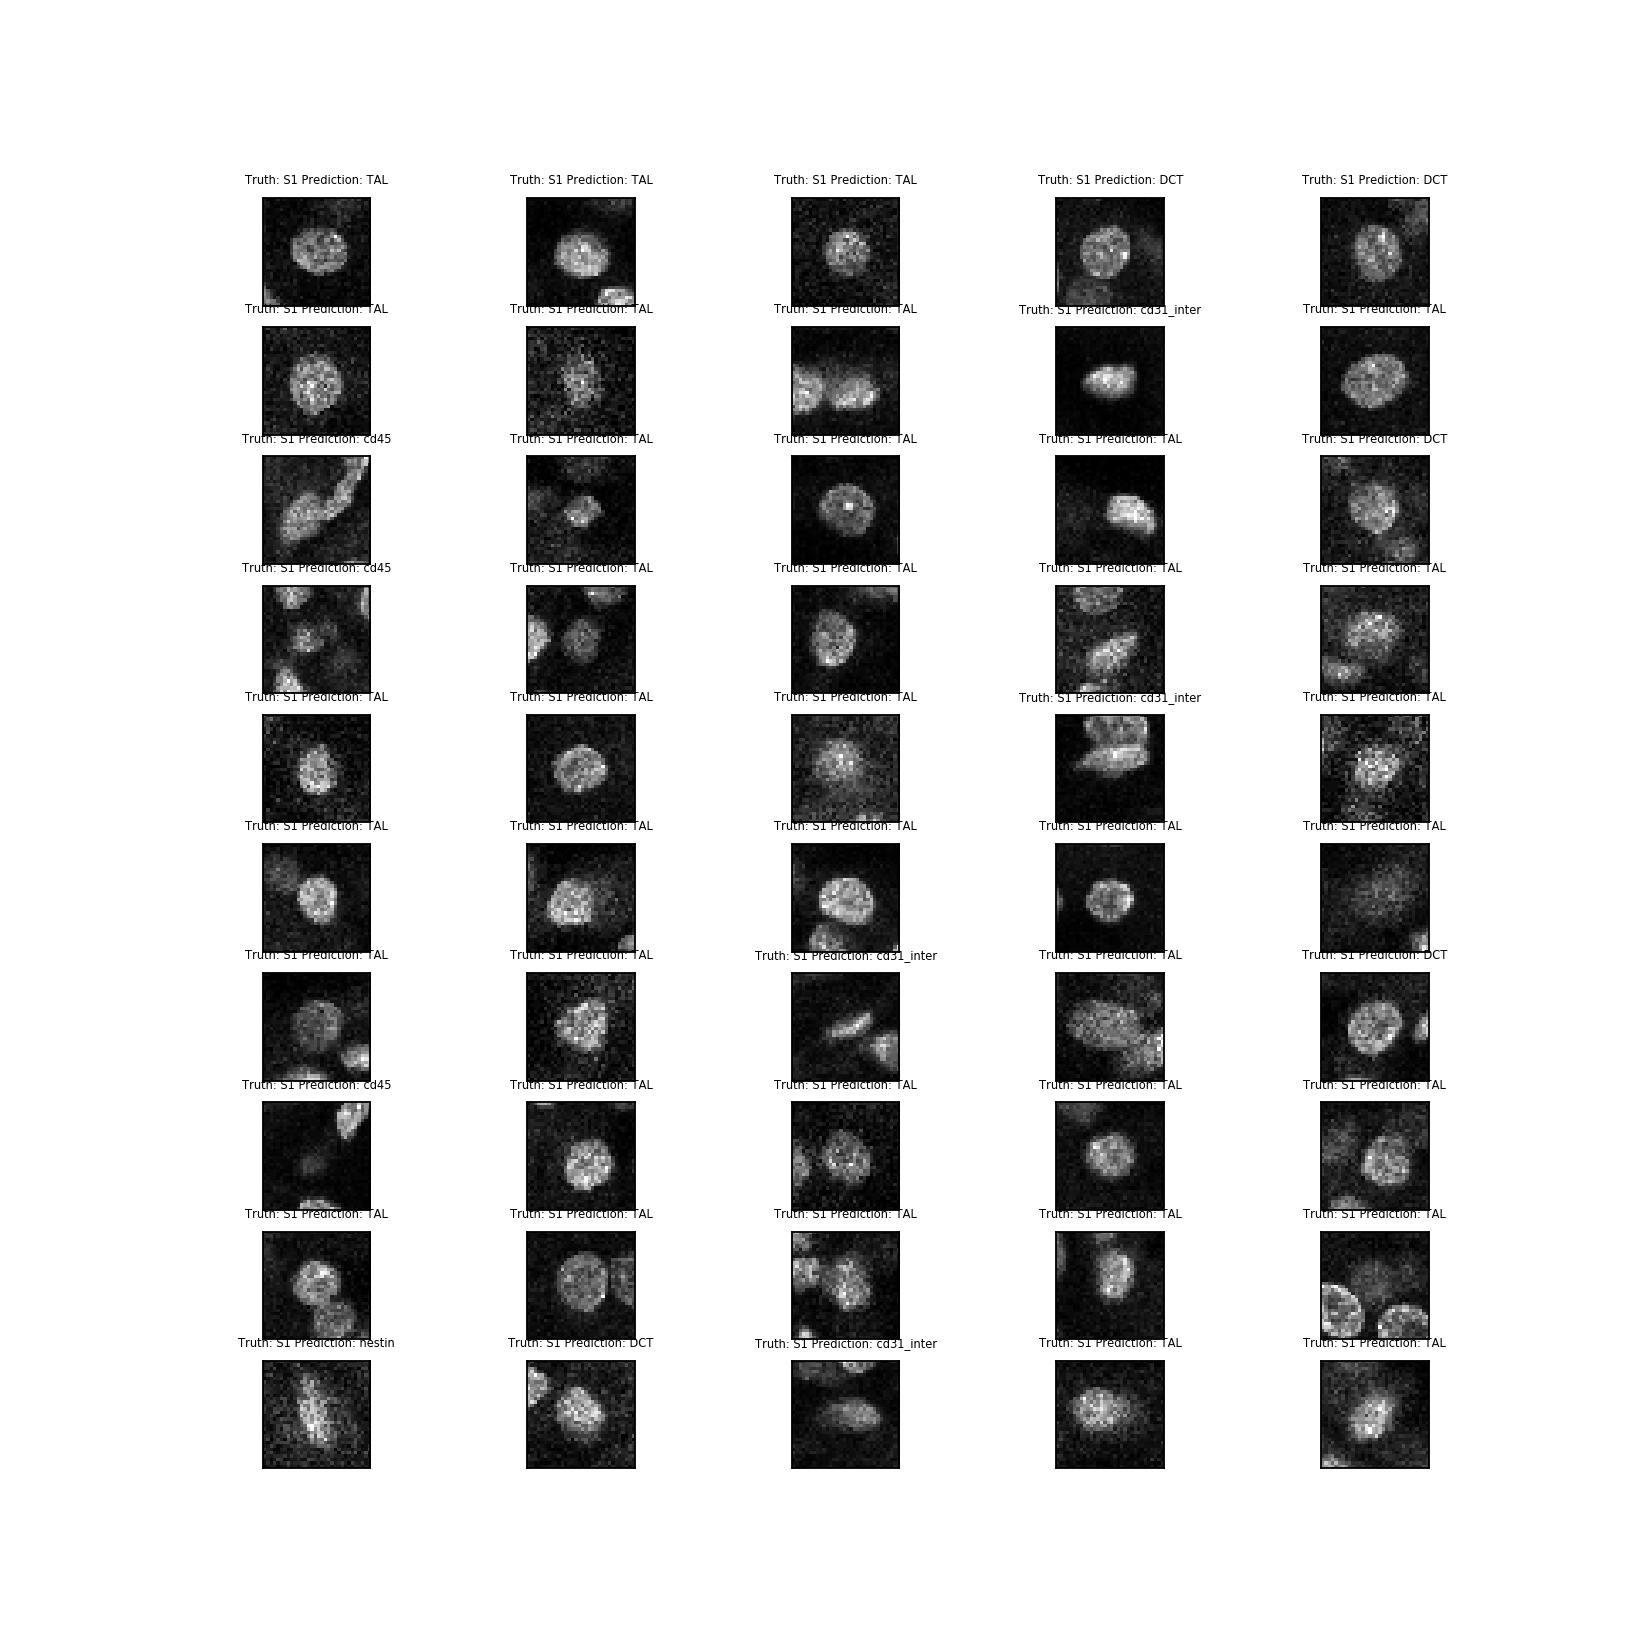

23536
[ 68815  59068  74365 130618  90760 115432 100424   7064 132011  73173
 114403 129323  75871 102431  40362 138737  21068 122988  40390  38530]


'\nremove images w/ low signal to noise \nSNR = 10*log(mean(img) / std(img))\n\n\n\n'

In [11]:
def showIm(idx, dataset, psx, classes):
    img, label = dataset.__getitem__(idx)
    img = img.data.numpy().squeeze()
    label = label
    pred = np.argmax(psx[idx])
    title = "Truth: {} Prediction: {}".format(classes[label], classes[pred])
    middle_slice = int(img.shape[0] / 2)
    plt.imshow(img[middle_slice], cmap = 'gray')
    plt.title(title)
    
    
def showIm2(idxs, dataset, psx, classes):
    imgs = []
    labels = []
    predictions = []
    for idx in range(len(idxs)):
        img, label = dataset.__getitem__(idx)
        if label == np.argmax(psx[idx]):
            continue
        if label == 0 and np.argmax(psx[idx]) == 1:
            continue
        if label == 1 and np.argmax(psx[idx]) == 0:
            continue
        img = img.data.numpy().squeeze()
        middle_slice = int(img.shape[0] / 2)
        imgs.append(img[middle_slice])
        labels.append(label)
        predictions.append(np.argmax(psx[idx]))
    
    pw = 5
    pl = 10
    fig, axs = plt.subplots(pl, pw, figsize=(10,10),facecolor='w', edgecolor='k')
    axs = axs.ravel()
    #fig.subplots_adjust(hspace = 0.25, wspace= -0.75)
    
    for i in range(pw*pl):
        title = "Truth: {} Prediction: {}".format(classes[labels[i]], classes[predictions[i]])
        axs[i].imshow(imgs[i], cmap = plt.cm.gray)
        axs[i].set_title(title, fontsize = 5)
        axs[i].set_xticks([])
        axs[i].set_yticks([])

        
#######################################################################        
        
        
label_errors_idx = cleanlab.pruning.order_label_errors(
    label_errors_bool = label_errors_bool,
    psx = psx,
    labels = labels,
    #sorted_index_method = 'normalized_margin',
    sorted_index_method = 'prob_given_label'
)

classes = ('S1', 'S2S3', 'TAL', 'DCT', 'CD', 'cd45', 'nestin', 'cd31_glom', 'cd31_inter')

toShow = 30

showIm2(label_errors_idx, train_dataset, psx, classes)




print(len(label_errors_idx))
print(label_errors_idx[:20])

#notes
'''
remove images w/ low signal to noise 
SNR = 10*log(mean(img) / std(img))



'''

In [41]:
from cleanlab.latent_estimation import estimate_py_and_noise_matrices_from_probabilities

print(np.unique(labels))

est_py, est_nm, est_inv, confident_joint = estimate_py_and_noise_matrices_from_probabilities(
    s=labels,
    psx=psx
)
print("fin")



[0 1 2 3 4 5 6 7 8]
fin


In [8]:
#REMOVE ALL BAD LABELS FROM TRAIN DATASET

filename = config['data_loader']['args']['hdf5_path']
path = filename.split('.')
path = path[0] + "_prune_bad_labels.h5"
print("NEW FILE " + path)
store = pd.HDFStore(path)
with pd.HDFStore(filename) as f:
        print()
        print("Successfully created " + path)
        print("===============")
        keys = list(f.keys())
        print("{0} keys in this file: {1}".format(len(keys), keys))
        
        num_images_train = f['Metadata']['TrainingNum'][0]
        num_images_test = f['Metadata']['TestingNum'][0]
        mean = f['Metadata']['TrainingMean'][0]
        std = f['Metadata']['TrainingStd'][0]
        mean_t = np.mean(f['test_data'].to_numpy())
        std_t = np.std(f['test_data'].to_numpy())
        
        print("Training images: " + str(num_images_train))
        print("Testing images: " + str(num_images_test))
        print("Training image mean = " + str(mean) + " and std = " + str(std))
        print("Testing image mean = " + str(mean_t) + " and std = " + str(std_t))
        
        train_data = f['train_data'].to_numpy()
        train_label = f['train_labels'].to_numpy()
        
        train_data = np.delete(train_data, label_errors_idx, axis = 0)
        train_label = np.delete(train_label, label_errors_idx, axis = 0)
        
        num_images_train = len(train_data)
        snrs = np.empty(num_images_train)
        for i in range(num_images_train):
            img = train_data[i]
            img = (img - mean) / std
            snr = np.mean(img) / np.std(img)
            snrs[i] = snr
        print(len(snrs))
        print("Mean SNR: {}".format(np.mean(snrs)))
        print("Std SNR: {}".format(np.std(snrs)))

        low_snr = np.where(snrs < np.mean(snrs) - np.std(snrs))[0] #all images with SNR < 1 standard deviation from the mean
        print("Total number of low snr images {}".format(len(low_snr)))
        
        train_data = np.delete(train_data, low_snr, axis = 0)
        train_label = np.delete(train_label, low_snr, axis = 0)
        
        store.append('train_data', pd.DataFrame(train_data.astype(np.int64)))
        store.append('train_labels', pd.DataFrame(train_label.astype(np.int64)))
        
        
        #REPEAT FOR TEST
        test_data = f['test_data'].to_numpy()
        test_label = f['test_labels'].to_numpy()
        snrs = np.empty(num_images_test)
        for i in range(num_images_test):
            img = test_data[i]
            img = (img - mean) / std
            snr = np.mean(img) / np.std(img)
            snrs[i] = snr
        print(len(snrs))
        print("Mean SNR: {}".format(np.mean(snrs)))
        print("Std SNR: {}".format(np.std(snrs)))

        low_snr = np.where(snrs < np.mean(snrs) - np.std(snrs))[0] #all images with SNR < 1 standard deviation from the mean
        print("Total number of low snr images {}".format(len(low_snr)))
        
        test_data = np.delete(test_data, low_snr, axis = 0)
        test_label = np.delete(test_label, low_snr, axis = 0)
        
        store.append('test_data', pd.DataFrame(test_data.astype(np.int64)))
        store.append('test_labels', pd.DataFrame(test_label.astype(np.int64)))
        
        
                
        metadata = pd.DataFrame({'TrainingNum': len(train_data), 'TestingNum': len(test_data), \
                'TrainingMean': np.mean(train_data), 'TrainingStd': np.std(train_data)}, index=[0])      
        store.append('Metadata', metadata)
        store.append('test_ids', f['test_ids'])

        print(metadata)
        
        del train_data
        print("FIN")
store.close()

with pd.HDFStore(path) as f:
        print('\n\n\n')
        print("Successfully created " + path)
        print("===============")
        keys = list(f.keys())
        print("{0} keys in this file: {1}".format(len(keys), keys))

NEW FILE C:/Users/awoloshu/Desktop/datasets/f33f44combined_noCNT/3d_all/f33f44combined_noCNT_3d_all_prune_bad_labels.h5

Successfully created C:/Users/awoloshu/Desktop/datasets/f33f44combined_noCNT/3d_all/f33f44combined_noCNT_3d_all_prune_bad_labels.h5
6 keys in this file: ['/Metadata', '/test_data', '/test_ids', '/test_labels', '/train_data', '/train_labels']
Training images: 118681
Testing images: 20936
Training image mean = 15.022874573172926 and std = 18.438763583389793
Testing image mean = 14.399334246014213 and std = 18.52662211585272
96632
Mean SNR: -0.2604929990664147
Std SNR: 0.7069048676692846
Total number of low snr images 11257


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tables\leaf.py:353: RuntimeWarning: overflow encountered in long_scalars
  expected_mb = (expectedrows * rowsize) // MB


20936
Mean SNR: -0.2854258253268697
Std SNR: 0.7137553278666308
Total number of low snr images 2488
   TrainingNum  TestingNum  TrainingMean  TrainingStd
0        85375       18448     15.747217    19.444072
FIN




Successfully created C:/Users/awoloshu/Desktop/datasets/f33f44combined_noCNT/3d_all/f33f44combined_noCNT_3d_all_prune_bad_labels.h5
6 keys in this file: ['/Metadata', '/test_data', '/test_ids', '/test_labels', '/train_data', '/train_labels']


In [ ]:
#CHANGE ALL BAD LABELS IN DATASET